# Анализ и визуализация целей обучения студентов "Яндекс Практикум"


---

## Проект был выполнен командой **Seven strangers**

**Участники команды:**

Дарья Саничева PM

Ирина Тетерева (Аналитик) \
Александр Трудолюбов (Аналитик) \
Алина Карасева(Аналитик)

Анастасия Горелова(дизайнер) \
Вероника Тихонова(дизайнер) \
Анастасия Дружкова(дизайнер)





**Краткое описание исследования:**

**Цель проекта:** используя данные, полученные с помощью опроса студентов Яндекс Практикума, определить цели студентов Яндекс Практикума и выстроить рекоммендации, которые будут способствовать помощи студентам в достижении этих целей

**Задачи проекта:**
1. Предобработать данные;
2. Определить основные цели студентов практикума; 
3. Построить портреты студентов, сравнить их, чтобы выделить значимые закономерности, сегментировать студентов, выявить особенности сегментов
4. Сформулировать на основе данных гипотезы по улучшению
выстраивания помощи студентам в достижении их целей
5. Oформить выводы и гипотезы для презентации руководству Яндекс Практикума.

<br>
<br>

**Описание датасета:**

data_goals_answers
* `question_title` — текст вопроса
* `question_type` — тип вопроса
* `user_id` — уникальный id пользователя
* `user_answer` — ответ пользователя на вопрос
* `answer_date` — время ответа
* `answer_id` — id ответа
* `cohort`, `current_cohort` — начальная и текущая когорта студента
* `course_name`, `topic_name`, `lesson_name` — курс, тема и урок, на котором студент отвечает на вопрос
   У нас значения должны быть Трудоустройство-Трудоустройство-Цель обучения, т.к. мы изучаем именно это
* `original_segment`, `current_segment` — b2c/b2b/b2g — из какого сегмента был/стал студент — сам является клиентом, его обучение оплачивается бизнесом или государством
* `profession_name` — код профессии
* `statement_content` — формулировка вопроса об уверенности в знаниях (в этой таблице нету)
* `slide_position` — страница опроса (не нужно для анализа)

hackathon_metrics
* `profession_name` — код профессии
* `user_id` — уникальный id пользователя
* `lp_avg_user` — средний learning performance 
   Первые, более высокие значения в таблице с фри-трека, последние с курса, наиболее актуально находящееся в таблице ниже
* `question_title` — текст вопроса
* `user_answer` — ответ пользователя на вопрос
* `statement_content` — формулировка вопроса об уверенности в знаниях 
* `value` — ответ на вопрос об уверенности в знаниях для расчёта learning experience индекса
<br>
<br>


**Ключевые выводы:**
Должен быть разный подход к построению работы с группами студентов на карьерном треке.

**Группа новички**, которые ищут работу активно - нужна помощь с оформлением артефактов, предоставление шаблонов резюме, сопроводительного письма, портфолио, и может быть ДЗ типа "запиши видеопрезентацию "Расскажите о себе". Проведение "тестовых собеседований"

**Группа профессионалы**, которые улучшить навыки - нужен коучинговый подход, работа в индивидуальном формате, персональная оценка навыков, может какое-то тестирование, составление плана развития.  

**Студенты из В2G**, больше других нацелены на смену работы и имеют меньший рост успеваемости, чем студенты из B2C и B2B. Также была замечена статистически значимая разница в росте успеваемости студентов B2G, которые заполняли опросник в четверг и в воскресенье, а также ранним утром и утром. Стоит провести дополнительное исследование на зависимость успеваемости и времени обучения.

**Оглавление:**


- Подготовка к анализу данных
- Подготовка данных
  - Предобработка данных
  - Объединение датафреймов
- Исследовательский анализ данных
  - Общее описание данных
  - Формирование целей студентов
- Портреты студентов
  - Сводные таблицы и хитмапы
  - Кластеризация студентов
- Сегментация студентов
- Гипотезы по улучшению выстраивания помощи студентам
- Итоговые выводы


<a id="start"></a>

## Подготовка к анализу данных

---



Раздел включает в себя:

1.   Подгрузку библиотек
2.   Загрузку данных
3.   Первый взгляд на данные




In [1]:
# Подгрузка библиотек
# Общие
import math as mth
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# Для сегментации студентов
from scipy import stats as st
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
# На случай, если будем возиться с текстовыми ответами 
from pymystem3 import Mystem 
m = Mystem()

In [2]:
#функция для подгрузки массивов с гугл диска
def google_downloader(url, file_type):
    file_id=url.split('/')[-2]
    dwn_url='https://drive.google.com/uc?id=' + file_id
    if file_type == 'csv':
      df = pd.read_csv(dwn_url, index_col=0)
      return df
    elif file_type == 'excel':
      df = pd.read_excel(dwn_url, index_col=0)
      return df

In [3]:
sns.set_theme()
sns.set_style("dark")
sns.color_palette("Blues", as_cmap=True)
sns.set(rc={'figure.figsize':(12,9)})
pd.set_option('display.precision', 3)
pd.options.display.max_colwidth = 1

In [4]:
# Подгрузка данных из общей папки
answers_df = google_downloader('https://docs.google.com/spreadsheets/d/1zbn2OZZkGXxBdClAsSSo4h5gWKSGyIdA/edit?usp=sharing&ouid=115121575002263209833&rtpof=true&sd=true', 'excel')
metrics_df = google_downloader('https://drive.google.com/file/d/1gvNk5EMyRKp407LEGS3CNlbsLEs08_ox/view?usp=sharing', 'csv')

In [5]:
# Подгрузка данных
#answers_df = pd.read_excel('/content/data_goals_answers_fin.xlsx', index_col=0)
#metrics_df = pd.read_csv('/content/hackathon_metrics.csv', index_col=0)

In [6]:
# Первый взгляд на данные
def fast_review(df):
    print ('Общий вид данных')
    display(df.sample(10, random_state = 0))
    print ('-------------------------')
    print ('Общая информация о данных')
    df.info()

In [7]:
fast_review(answers_df)

Общий вид данных


,user_id,answer_date,answer_id,cohort,course_name,current_cohort,current_segment,lesson_name,original_segment,profession_name,question_title,question_type,slide_position,statement_content,topic_name,user_answer
3942,618263,2023-08-18 23:00:00,ee96195c-dc56-4e0c-8ef1-805f2323a256,data_cohort_119,Трудоустройство,data_cohort_119,b2g,Цель обучения,b2g,data-analyst,"Тут вы можете оставить свой комментарий, если не нашли подходящего варианта ответа.",text,1,NaN,Трудоустройство,-
13693,5991613,2023-09-19 19:32:00,f19bd5b7-b7db-436d-a51c-9bb074e78d61,data_cohort_107,Трудоустройство,data_cohort_107,b2c,Цель обучения,b2g,data-analyst,"Для программы важно понять над чем вам нужно поработать. Не переживайте, вам будут доступны все опции.",checkbox,0,NaN,Трудоустройство,решение тестовых заданий
41917,15368633,2023-07-20 10:11:00,9e2c71ab-d0bc-4644-8fbd-a5763b28d67c,sql-data-analyst_cohort_139,Трудоустройство,sql-data-analyst_cohort_139,b2c,Цель обучения,b2c,sql-data-analyst,"Для программы важно понять над чем вам нужно поработать. Не переживайте, вам будут доступны все опции.",checkbox,0,NaN,Трудоустройство,определение стратегии поиска работы
5489,1011868,2023-07-31 18:44:00,d8f14bdf-434e-4b7f-b9fc-224cc5574fbc,ds_cohort_103,Трудоустройство,ds_cohort_103,b2g,Цель обучения,b2g,data-scientist,"Для программы важно понять над чем вам нужно поработать. Не переживайте, вам будут доступны все опции.",checkbox,0,NaN,Трудоустройство,оценка шансов на трудоустройство
42559,15472260,2023-09-25 21:53:00,27d6a92c-b58e-4ac4-9d49-10fe3e927f4b,systems_analyst_cohort_13,Трудоустройство,systems_analyst_cohort_13,b2c,Цель обучения,b2c,systems-analyst,"Для программы важно понять над чем вам нужно поработать. Не переживайте, вам будут доступны все опции.",checkbox,0,NaN,Трудоустройство,как и куда можно расти как специалисту
34761,14917769,2023-07-31 10:18:00,8a4c4738-2b36-4053-bdb4-58acc827af63,ds_cohort_103,Трудоустройство,ds_cohort_103,b2g,Цель обучения,b2g,data-scientist,"Для программы важно понять над чем вам нужно поработать. Не переживайте, вам будут доступны все опции.",checkbox,0,NaN,Трудоустройство,оформление портфолио
22504,13913671,2023-07-31 23:59:00,01532c20-1392-400f-a05d-ff20c9f5a233,sql-data-analyst_cohort_103,Трудоустройство,sql-data-analyst_cohort_103,b2c,Цель обучения,b2c,sql-data-analyst,"Для программы важно понять над чем вам нужно поработать. Не переживайте, вам будут доступны все опции.",checkbox,0,NaN,Трудоустройство,определение профессиональной сферы
41612,15327691,2023-09-13 01:34:00,ae32822c-0e04-458b-b751-7d4f79a03cb3,data_cohort_123,Трудоустройство,data_cohort_123,b2g,Цель обучения,b2g,data-analyst,Планируете ли вы записаться на Карьерный Трек?,radio,1,NaN,Трудоустройство,"Да, уже записался"
21068,13441852,2023-09-18 20:40:00,fab22efd-b75a-473c-b470-a79a76671934,ds_cohort_1091,Трудоустройство,ds_cohort_1091,b2c,Цель обучения,b2c,data-scientist,"Для программы важно понять над чем вам нужно поработать. Не переживайте, вам будут доступны все опции.",checkbox,0,NaN,Трудоустройство,как говорить про повышение
3016,442337,2023-09-18 20:38:00,872dc3c7-c23f-44b2-9d56-df841c6c95f5,systems_analyst_cohort_13,Трудоустройство,systems_analyst_cohort_13,b2c,Цель обучения,b2c,systems-analyst,"Для программы важно понять над чем вам нужно поработать. Не переживайте, вам будут доступны все опции.",checkbox,0,NaN,Трудоустройство,как и куда можно расти как специалисту


-------------------------
Общая информация о данных
<class 'pandas.core.frame.DataFrame'>
Int64Index: 43428 entries, 1 to 43428
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            43428 non-null  int64  
 1   answer_date        43428 non-null  object 
 2   answer_id          43428 non-null  object 
 3   cohort             43428 non-null  object 
 4   course_name        43428 non-null  object 
 5   current_cohort     43428 non-null  object 
 6   current_segment    43223 non-null  object 
 7   lesson_name        43428 non-null  object 
 8   original_segment   43223 non-null  object 
 9   profession_name    43428 non-null  object 
 10  question_title     43428 non-null  object 
 11  question_type      43428 non-null  object 
 12  slide_position     43428 non-null  int64  
 13  statement_content  0 non-null      float64
 14  topic_name         43428 non-null  object 
 15  user_answer       

В данных содержатся 43 428 строк и 16 столбцов, характеризующие ответы студентов. Наблюдаются пропущенные значения в части сегмента студента (original segment) и текстового ответа студентов (user_answer). Также отсутствуют данные в столбце statement_content, как и было указано в задании.  

В ТЗ также указано, что столбцы с наименованием курса должны содержать одну и ту же информацию по трудоустройству, поэтому для целей анализа мы удалим эти столбцы (slide_position, course_name, topic_name, lesson_name).

Далее для анализа также удалим столбец slide_position, так как информация нерелевантна для принятия решений.

Видим, что в массиве с ответами некорректный тип данных у следующих столбцов:
- `answer_date` - нужно сделать datetime вместо object
- `original_segment` и `current_segment` - можно превратить в категориальные переменные
- аналогично для `question_type      `

In [8]:
fast_review(metrics_df)

Общий вид данных


,profession_name,user_id,lp_avg_user,statement_content,value,question_title,user_answer
74868,data-analyst-plus,14998076,0.640,Моя уверенность в своих знаниях значительно повысилась по сравнению с предыдущим спринтом,0,NaN,NaN
13296,data-scientist-plus,14393913,0.830,Моя уверенность в своих знаниях значительно повысилась по сравнению с предыдущим спринтом,2,NaN,NaN
41401,data-analyst,526470,0.830,Моя уверенность в своих знаниях значительно повысилась по сравнению с предыдущим спринтом,2,NaN,NaN
17356,data-scientist,14193798,0.810,Моя уверенность в своих знаниях значительно повысилась по сравнению с предыдущим спринтом,2,NaN,NaN
60750,data-scientist,2125737,0.670,Моя уверенность в своих знаниях значительно повысилась по сравнению с предыдущим спринтом,1,NaN,NaN
35343,data-analyst,14310072,0.720,Моя уверенность в своих знаниях значительно повысилась по сравнению с предыдущим спринтом,1,NaN,NaN
70252,data-scientist,8919289,0.638,Моя уверенность в своих знаниях значительно повысилась по сравнению с предыдущим спринтом,2,NaN,NaN
22520,data-scientist,1182317,0.870,Моя уверенность в своих знаниях значительно повысилась по сравнению с предыдущим спринтом,1,NaN,NaN
63587,data-scientist,15045363,0.696,Моя уверенность в своих знаниях значительно повысилась по сравнению с предыдущим спринтом,-1,NaN,NaN
53801,systems-analyst,15769045,0.970,Моя уверенность в своих знаниях значительно повысилась по сравнению с предыдущим спринтом,2,NaN,NaN


-------------------------
Общая информация о данных
<class 'pandas.core.frame.DataFrame'>
Int64Index: 79117 entries, 0 to 79116
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   profession_name    79117 non-null  object 
 1   user_id            79117 non-null  int64  
 2   lp_avg_user        79117 non-null  float64
 3   statement_content  79117 non-null  object 
 4   value              79117 non-null  int64  
 5   question_title     14739 non-null  object 
 6   user_answer        14739 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 4.8+ MB


Датасет содержит 79 117 строк и 7 столбцов, характеризующие оценку студентами некоторого предложения, который определен, как метрика. Наблюдаются пропущенные значения в части  теста вопроса и ответа студента на вопросы.

Данные имеют корректный тип. 

**Выводы по разделу:**

- Данные подгружены
- Обнаружено большое количество пропусков в ряде переменных
- Обнаружены переменные, у которых лучше исправить тип данных 
- Нужно удалить колонки, которые не имеют отношения к теме исследования, дублируют значения других столбцов или одинаковы во всех строках: `statement_content` в `answers_df`, `slide_position`, `course_name`, `topic_name`, `lesson_name`. 

## Подготовка данных


---

Раздел включает в себя поиск и устранение ошибок в данных:
- Пропусков
- Дубликатов
- Исправление типов переменных

После будет проведено объединение датафреймов.


### Предобработка данных

In [9]:
#Функция для обзора данных
def miss_table(data):
    missings = pd.DataFrame(data.isna().mean()*100, columns = ['% miss'])
    missings['# miss'] = pd.DataFrame(data.isna().sum())
    display (missings.style.background_gradient('coolwarm'))

In [10]:
def des_var(data):
    for i in list(data):
        if (data[i].dtypes!='object') and (data[i].nunique() > 10):
             display (data[i].describe())
        else: 
            display (data[i].value_counts())
        print ('------------------------------')
        print (' ')

In [11]:
def united_description(df):
    print ('Общая информация о массиве')
    df.info()
    print ('-----------------------------')
    print ('Наличие пропусков в данных')
    miss_table(df)
    print ('-----------------------------')
    print ('Общее описание переменных')
    des_var(df)
    print ('-----------------------------')
    print ('Количество дубликатов: {}'.format(df.duplicated().sum()))

In [12]:
# Функция для проверки соответствия данных в столбцах, на вход уникальные значения в столбцах
def conformity(var1, var2): 
    res = pd.Series(var1).isin(var2).sum()/len(var1)
    print(f'в var1 всего элементов {len(var1)}'.format(var1))
    print(f'в var2 всего элементов {len(var2)}'.format(var2))
    print('совпадает {:,.2%}'.format(res))

In [13]:
#проверим столбцы на наличие дополнительных данных в столбцах 'course_name', 
#'lesson_name', 'slide_position', 'topic_name'

columns = ['course_name', 'lesson_name', 'slide_position', 'topic_name']

for item in columns:
  print(answers_df[item].value_counts())

Трудоустройство    43428
Name: course_name, dtype: int64
Цель обучения    43428
Name: lesson_name, dtype: int64
0    36405
1    7023 
Name: slide_position, dtype: int64
Трудоустройство    43428
Name: topic_name, dtype: int64


В столбцах указана информация только по курсу "трудоустройство" как цель обучения. Далее удалим эти столбцы из анализа

In [14]:
# Для начала удалим лишние столбцы, чтобы не захламляли тетрадку
answers_df = answers_df.drop(columns=['course_name', 'lesson_name', 'slide_position', 'statement_content', 'topic_name'])

In [15]:
#Обзор 1го датафрейма
united_description(answers_df)

Общая информация о массиве
<class 'pandas.core.frame.DataFrame'>
Int64Index: 43428 entries, 1 to 43428
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_id           43428 non-null  int64 
 1   answer_date       43428 non-null  object
 2   answer_id         43428 non-null  object
 3   cohort            43428 non-null  object
 4   current_cohort    43428 non-null  object
 5   current_segment   43223 non-null  object
 6   original_segment  43223 non-null  object
 7   profession_name   43428 non-null  object
 8   question_title    43428 non-null  object
 9   question_type     43428 non-null  object
 10  user_answer       43416 non-null  object
dtypes: int64(1), object(10)
memory usage: 4.0+ MB
-----------------------------
Наличие пропусков в данных


,% miss,# miss
user_id,0.000000,0
answer_date,0.000000,0
answer_id,0.000000,0
cohort,0.000000,0
current_cohort,0.000000,0
current_segment,0.472046,205
original_segment,0.472046,205
profession_name,0.000000,0
question_title,0.000000,0
question_type,0.000000,0


-----------------------------
Общее описание переменных


count    4.343e+04
mean     9.978e+06
std      5.840e+06
min      3.157e+03
25%      3.168e+06
50%      1.374e+07
75%      1.481e+07
max      1.654e+07
Name: user_id, dtype: float64

------------------------------
 


2023-09-11 10:38:00    58
2023-08-28 10:17:00    35
2023-07-06 11:25:00    33
2023-08-28 13:39:00    33
2023-09-26 20:12:00    32
                       ..
2023-07-13 15:01:00    1 
2023-09-10 23:44:00    1 
2023-08-02 11:45:00    1 
2023-08-18 11:41:00    1 
2023-09-04 12:39:00    1 
Name: answer_date, Length: 7882, dtype: int64

------------------------------
 


076646fa-5e3f-4bb1-a90f-bea31c80a282    13
9cbf8a73-9d8b-47d8-bc90-dceb93706209    13
829e81e7-f363-4ce2-abaa-da4ab43fd374    13
8a437a6f-9b87-4ab7-bf33-667a37a6041d    13
8aabdbaf-edf6-4593-9c4d-52ffb75c3d33    13
                                        ..
3f90c0ed-28e3-4cc6-9f2f-c22ac9e18950    1 
efda4e73-5877-4be2-ac70-ed87cab762d9    1 
87b4f061-a455-4509-9867-44d885fe0506    1 
a76308ea-ce9e-4b85-85a5-90ddb2b6fe47    1 
76c6f444-938f-47e5-b990-f8bce2bc4a85    1 
Name: answer_id, Length: 14094, dtype: int64

------------------------------
 


data_cohort_119                3411
ds_cohort_109                  2837
ds_cohort_107                  2689
data_cohort_117                2665
data_cohort_121                2650
                               ... 
sql-data-analyst_cohort_135    6   
sql-for-analyst_cohort_5       6   
sql-data-analyst_cohort_137    6   
data_analyst_plus_cohort_29    3   
ds_cohort_63                   1   
Name: cohort, Length: 169, dtype: int64

------------------------------
 


data_cohort_119                3757
ds_cohort_109                  2965
data_cohort_121                2946
ds_cohort_107                  2700
data_cohort_123                2613
                               ... 
sql-data-analyst_cohort_75     6   
sql-data-analyst_cohort_137    6   
sql-for-analyst_cohort_5       6   
data_analyst_plus_cohort_29    3   
ds_cohort_63                   1   
Name: current_cohort, Length: 173, dtype: int64

------------------------------
 


b2c    21568
b2g    21422
b2b    233  
Name: current_segment, dtype: int64

------------------------------
 


b2g    22415
b2c    20575
b2b    233  
Name: original_segment, dtype: int64

------------------------------
 


data-analyst             18651
data-scientist           14893
systems-analyst          3676 
data-analyst-plus        2367 
sql-data-analyst         1593 
data-scientist-plus      1405 
datavis-and-bi-tools     278  
data-analyst-bootcamp    217  
data-engineer            151  
math-for-da-ds           102  
data-science-bootcamp    95   
Name: profession_name, dtype: int64

------------------------------
 


Для программы важно понять над чем вам нужно поработать. Не переживайте, вам будут доступны все опции.                                                                                                                                                                 25822
В зависимости от опыта работы вам может понадобиться разный вид консультаций и помощи от команды сопровождения и трудоустройства. Для нас очень важен честный ответ и понимание вашего бэкграунда.                                                                     3560 
Бывает, что во время обучения меняется его цель. Например, изначально вы не планировали менять работу, но влюбились в профессию. Может, произошли жизненные изменения или вам сложно определить цель. Чтобы мы поняли, как помочь, отметьте подходящее утверждение:    3534 
Планируете ли вы записаться на Карьерный Трек?                                                                                                                                                   

------------------------------
 


checkbox    25822
radio       14117
text        3489 
Name: question_type, dtype: int64

------------------------------
 


Нет                                                                         2745
резюме                                                                      2687
оформление портфолио                                                        2606
прохождение собеседований                                                   2587
решение тестовых заданий                                                    2436
                                                                            ... 
Нужно будет брать академ и проходить этот момент ещё раз                    1   
M                                                                           1   
Пока карьерный трек мне не нужен, но я запишусь после дипломного проекта    1   
Пока спросить нечего.                                                       1   
Не берут без опыта работы                                                   1   
Name: user_answer, Length: 1102, dtype: int64

------------------------------
 
-----------------------------
Количество дубликатов: 0


По результатам обзора 1го датафрейма отмечаем следующие моменты:
- Неправильные типы данных у переменных, о которых писали выше
- Крайне незначительное (менее 1% строк) количество пропусков в трех переменных, их можно удалить. Или заменить на "no info".
- Видим несовпадения в данных по когортам, то есть в датафрейме есть студенты, переходившие из одной когорты в другую.
- Аналогичная ситуация в сегменте - есть студенты, переходившие из b2g в b2c. 
- В опроснике 5 вопросов (1 из которых - просьба пояснить текстом).     
- В датафрйеме отсутствуют дубликаты.

In [16]:
#Меняем тип данных для answer_date
answers_df['answer_date'] = pd.to_datetime(answers_df['answer_date'])

In [17]:
#Удаляем пропуски
answers_df = answers_df.dropna()

Готово. Пропуски удалены, тип данных скорректирован.

In [18]:
#Обзор 2го датафрейма
united_description(metrics_df)

Общая информация о массиве
<class 'pandas.core.frame.DataFrame'>
Int64Index: 79117 entries, 0 to 79116
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   profession_name    79117 non-null  object 
 1   user_id            79117 non-null  int64  
 2   lp_avg_user        79117 non-null  float64
 3   statement_content  79117 non-null  object 
 4   value              79117 non-null  int64  
 5   question_title     14739 non-null  object 
 6   user_answer        14739 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 4.8+ MB
-----------------------------
Наличие пропусков в данных


,% miss,# miss
profession_name,0.000000,0
user_id,0.000000,0
lp_avg_user,0.000000,0
statement_content,0.000000,0
value,0.000000,0
question_title,81.370628,64378
user_answer,81.370628,64378


-----------------------------
Общее описание переменных


data-analyst             32077
data-scientist           28573
systems-analyst          4600 
data-analyst-plus        3029 
sql-data-analyst         2712 
data-scientist-plus      2691 
data-engineer            2434 
math-for-da-ds           1813 
data-analyst-bootcamp    793  
data-science-bootcamp    395  
Name: profession_name, dtype: int64

------------------------------
 


count    7.912e+04
mean     1.018e+07
std      5.894e+06
min      3.770e+02
25%      3.355e+06
50%      1.396e+07
75%      1.497e+07
max      1.613e+07
Name: user_id, dtype: float64

------------------------------
 


count    79117.000
mean     0.720    
std      0.125    
min      0.140    
25%      0.634    
50%      0.725    
75%      0.811    
max      0.980    
Name: lp_avg_user, dtype: float64

------------------------------
 


Моя уверенность в своих знаниях значительно повысилась по сравнению с предыдущим спринтом    79117
Name: statement_content, dtype: int64

------------------------------
 


 1    28424
 2    28088
 0    13718
-1    6028 
-2    2859 
Name: value, dtype: int64

------------------------------
 


Какова вероятность, что вы порекомендуете Практикум своим друзьям по шкале от 0 до 10, где 10 — обязательно порекомендую, 0 — не порекомендую ни за что?    14739
Name: question_title, dtype: int64

------------------------------
 


count    14739.000
mean     8.067    
std      2.247    
min      0.000    
25%      7.000    
50%      9.000    
75%      10.000   
max      10.000   
Name: user_answer, dtype: float64

------------------------------
 
-----------------------------
Количество дубликатов: 41817


In [19]:
# Смотрим различия в индексах пропусков user_answer и question_title.
conformity(metrics_df['user_answer'].isna().index,metrics_df['question_title'].isna().index)

в var1 всего элементов 79117
в var2 всего элементов 79117
совпадает 100.00%


Отлично, пропуски в одинаковых местах, значит, можно переименовывать столбец `user_answer` в `user_recommend_value` и удалять `question_title`

По результатам обзора 2го датафрейма можно выделить следующие моменты:
- Корректные типы данных.
- Большое количество пропусков в `question_title` и `user_answer`, что является особенностью данных. Пропуски заменим пустым значением "no info".
- `statement_content` - столбец с одним значением, можно переименовать колонку value в value_statement_content и удалить statement_content
- `question_title` - то же самое
- Много дубликатов, которые вызваны отсутствием даты при выгрузке из БД


In [20]:
# Доля дубликатов
print ('Доля дубликатов в датафрейме {:,.2%}'.format(metrics_df.duplicated().sum()/len(metrics_df)))

Доля дубликатов в датафрейме 52.85%


In [21]:
# Удалим statement_content, question_title и переименуем value в value_statement_content и user_answer в user_recommend_value
metrics_df.drop(columns=['statement_content', 'question_title'], inplace=True)
metrics_df.rename(columns={'value':'value_statement_content',
                           'user_answer':'user_recommend_value'}, 
                  inplace=True)

In [22]:
# Проверка результата
metrics_df.sample()

,profession_name,user_id,lp_avg_user,value_statement_content,user_recommend_value
72036,data-analyst,289480,0.81,2,8.0


Всё в порядке! В metrics_df остались только важные данные.   
`profession_name` - название профессии должно совпадать с таким же полем в другой таблице ответов   
`user_id` -	ID студента  
`lp_avg_user`	- средний learning performance студента  
`value_statement_content`	- оценка студентом уровня повышения своих знаний, по результатам нового спринта  
`user_recommend_value` - оценка студентом вероятности рекомендации  

Объединение фреймов лучше делать по двум колонкам `user_id` и `profession_name`, так мы не запутаем данные. Если студент менял профессию у нас будет пропуск в показателях `metrics_df` после объединения. 

При объединении данных будем использовать самую нижнюю оценку в датафрейме для каждого пользователя, так как она будет характеризовать самую последнюю оценку для пользователя.

### Объединение датафреймов

In [23]:
# Совпадение ид в таблицах
conformity(answers_df['user_id'].unique(),metrics_df['user_id'].unique())

в var1 всего элементов 3524
в var2 всего элементов 9797
совпадает 89.19%



только 89.19% студентов из answers_df есть в metrics_df, значит, при объединении мы потеряем часть данных.

In [24]:
# Совпадение профессий в таблицах
conformity(answers_df['profession_name'].unique(),metrics_df['profession_name'].unique())


в var1 всего элементов 11
в var2 всего элементов 10
совпадает 90.91%


In [25]:
set(answers_df['profession_name'].unique())-set(metrics_df['profession_name'].unique())

{'datavis-and-bi-tools'}

У нас нет метрик по студентам из профессии datavis-and-bi-tools, остальные на месте

In [26]:
# Преобразуем таблицу с метриками в новую с усредненными показателями
# По оценке успеваемости студентов также добавляем первую и последню из его оценок

metrics_df_redone = metrics_df.pivot_table(index = 'user_id',
                       values = ['lp_avg_user', 'value_statement_content', 'user_recommend_value'],
                      aggfunc = {'lp_avg_user':['first', 'last'],
                                'value_statement_content': 'mean',
                                'user_recommend_value':lambda x: x.mean(skipna=True)})

metrics_df_redone = metrics_df_redone.reset_index()

metrics_df_redone.columns = ['user_id',
                             'first_perf_evaluation',
                'last_perf_evaluation',
                'mean_user_recommend_value',
               'mean_value_statement_content']

metrics_df_redone

,user_id,first_perf_evaluation,last_perf_evaluation,mean_user_recommend_value,mean_value_statement_content
0,377,0.870,0.794,NaN,1.333
1,774,0.666,0.666,NaN,0.000
2,802,0.773,0.865,NaN,0.000
3,1282,0.670,0.570,NaN,0.500
4,1400,0.727,0.750,NaN,0.250
...,...,...,...,...,...
9792,16098368,0.723,0.790,NaN,0.000
9793,16098455,0.688,0.750,NaN,0.000
9794,16099590,0.806,0.810,NaN,1.000
9795,16100018,0.800,0.635,NaN,0.000


In [27]:
# Сравнение изменений по когортам
# Таблица со всеми когортами для каждого студента 	

metrics_df_redone['is_perf_grow'] = np.where((metrics_df_redone['first_perf_evaluation']<metrics_df_redone['last_perf_evaluation']),1,0)

metrics_df_redone = metrics_df_redone[['user_id','last_perf_evaluation',
                                       'is_perf_grow', 'mean_user_recommend_value', 'mean_value_statement_content']]
metrics_df_redone

,user_id,last_perf_evaluation,is_perf_grow,mean_user_recommend_value,mean_value_statement_content
0,377,0.794,0,NaN,1.333
1,774,0.666,0,NaN,0.000
2,802,0.865,1,NaN,0.000
3,1282,0.570,0,NaN,0.500
4,1400,0.750,1,NaN,0.250
...,...,...,...,...,...
9792,16098368,0.790,1,NaN,0.000
9793,16098455,0.750,1,NaN,0.000
9794,16099590,0.810,1,NaN,1.000
9795,16100018,0.635,0,NaN,0.000


Мы преобразовали таблицу с метриками в соответствующий вид, в следующем разделе мы превратим таблицу с ответами в широкую и уже там проведем объединение.

### Выводы

* Предобработали датасеты: избавились от дубликатов, пропущенных значений, поправили типы данных, убрали лишние столбцы

* преобразовали таблицу с метриками в соответствующий вид, в следующем разделе мы превратим таблицу с ответами в широкую и уже там проведем объединение.

## Исследовательский анализ данных

---


**Описание раздела:**

В данном разделе будут сформированы финальные данные, сгруппированные по ID, а также рассмотрены взаимосвязи между ответам на вопросы. 

Также будут сформулированы гипотезы, отражающие взаимосвязи целей пользователя курса по трудоустройству и факторов, которые могут повлиять на осуществление целей.



### Общее описание данных

#### Смотрим на данные в колонках answers_df  


##### answer_date	

In [28]:
print('Минимальная дата ответа', answers_df['answer_date'].min(), 'Максимальная дата ответа', answers_df['answer_date'].max())
print('Всего дат',answers_df['answer_date'].dt.date.nunique())

Минимальная дата ответа 2023-07-05 20:31:00 Максимальная дата ответа 2023-09-28 11:48:00
Всего дат 86


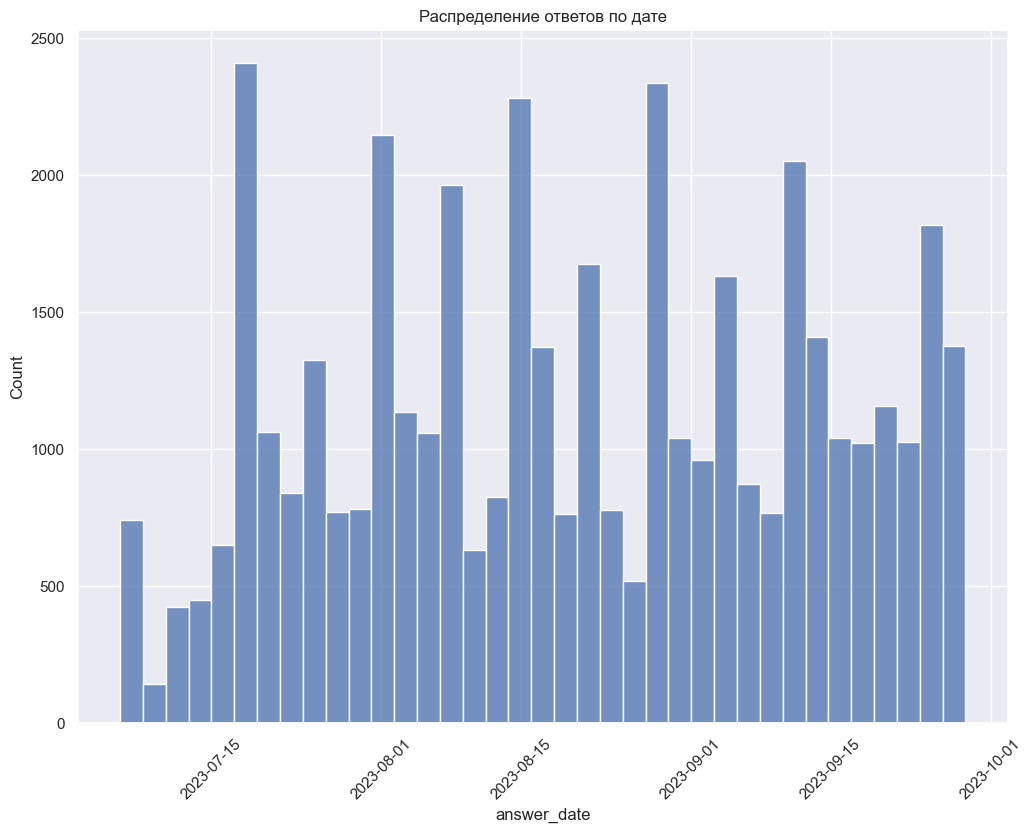

In [29]:
# answer_date найти минимальное и максимальное, посмотреть распределение количества ответов по дням
sns.histplot(data=answers_df, x='answer_date')

plt.title("Распределение ответов по дате")
plt.xticks(rotation=45);

Видим что-то похожее на сезонность (чаще всего ответы появляются в понедельник или вторник). Добавим дни недели, разделим на дату и время

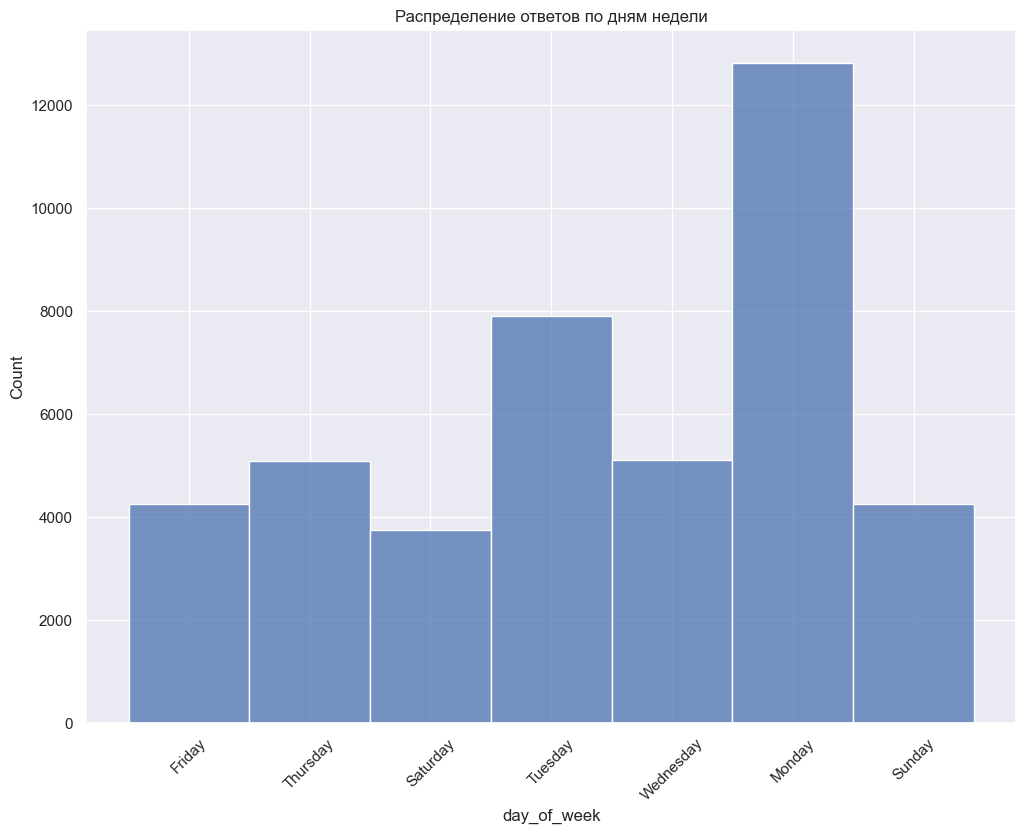

In [30]:
# дни недели
answers_df['day_of_week'] = answers_df['answer_date'].dt.day_name()
sns.histplot(data=answers_df, x='day_of_week')

plt.title("Распределение ответов по дням недели")
plt.xticks(rotation=45);

В понедельники и вторники больше всего ответов

In [31]:
answers_df['hour'] = answers_df['answer_date'].dt.hour
answers_df['answer_date'] = answers_df['answer_date'].dt.date

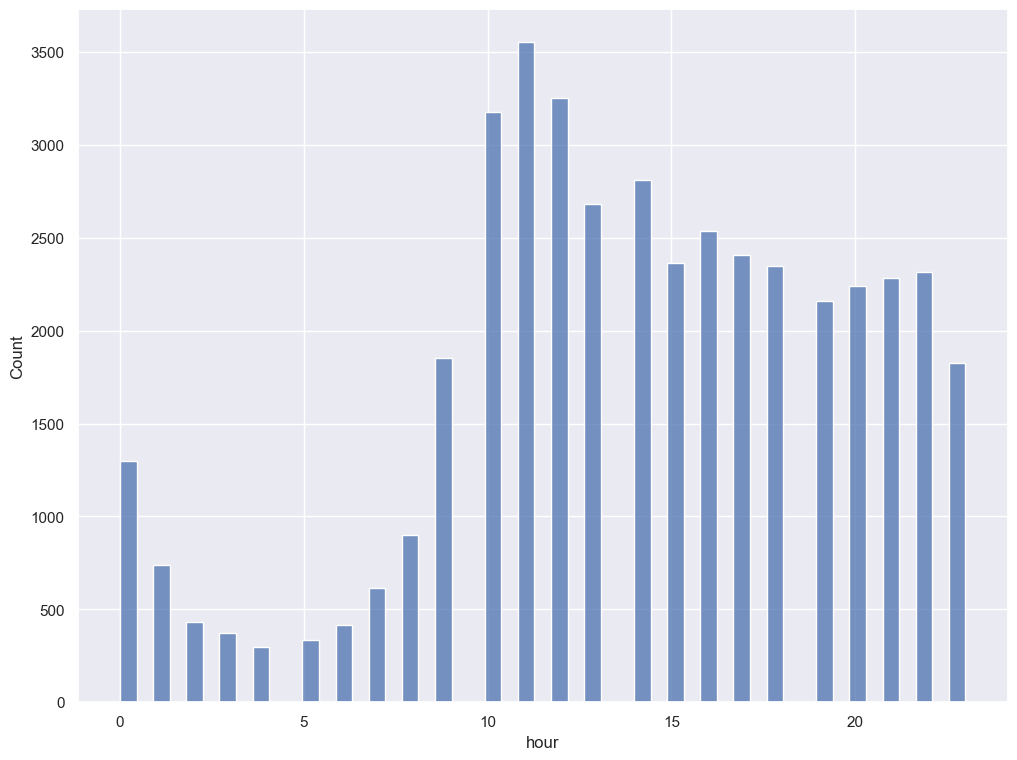

In [32]:
sns.histplot(data=answers_df, x='hour');

Наиболее активное время обучения - день.  
Можно поставить метки для категоризации времени суток

In [33]:
# Метки времени
answers_df['hour'] = (answers_df['hour'] % 24 + 4) // 4
answers_df['hour'].replace({1: 'Late Night',
                      2: 'Early Morning',
                      3: 'Morning',
                      4: 'Noon',
                      5: 'Evening',
                      6: 'Night'}, inplace=True)

In [34]:
# Наиболее частовстречающееся значение (мода) дня недели при ответе на вопросы для каждого студента
users_day_mode = answers_df.groupby('user_id')['day_of_week'].agg(lambda x: x.mode()).reset_index()

# Наиболее частовстречающееся значение (мода) времени при ответе на вопросы для каждого студента
users_hour_mode = answers_df.groupby('user_id')['hour'].agg(lambda x: x.mode()).reset_index()

# Объединим
users_time_mode = users_day_mode.merge(users_hour_mode, on='user_id')

users_time_mode

,user_id,day_of_week,hour
0,3157,Friday,Morning
1,5415,Thursday,Noon
2,8199,Saturday,Evening
3,8215,Tuesday,Night
4,10202,Tuesday,Noon
...,...,...,...
3519,16224921,Tuesday,Evening
3520,16230604,Saturday,Night
3521,16271708,Sunday,Evening
3522,16501153,Monday,Noon


In [35]:
print (users_time_mode['day_of_week'].value_counts())
print ('-------')
print (users_time_mode['hour'].value_counts())

Monday                 1046
Tuesday                648 
Wednesday              424 
Thursday               416 
Friday                 346 
Sunday                 339 
Saturday               303 
[Monday, Wednesday]    1   
[Saturday, Tuesday]    1   
Name: day_of_week, dtype: int64
-------
Noon                913
Morning             768
Evening             762
Night               707
Late Night          236
Early Morning       135
[Morning, Noon]     1  
[Morning, Night]    1  
[Evening, Noon]     1  
Name: hour, dtype: int64


Находим сдвоенные варианты, их необходимо убрать.

In [36]:
#Код, с помощью которого ищем индексы кривых строк

for i in range(len(users_time_mode)):
  if type(users_time_mode['hour'][i])!=str:
    print(i)

1658
1769
3147


In [37]:
# Замена на первое значение из списка
users_time_mode.loc[1769, 'day_of_week'] = 'Monday'
users_time_mode.loc[2120, 'day_of_week'] = 'Saturday'
users_time_mode.loc[1658, 'hour'] = 'Morning'
users_time_mode.loc[1769, 'hour'] = 'Morning'
users_time_mode.loc[3147, 'hour'] = 'Evening'

In [38]:
def bar_plot_t (list_of_param):
  
  fig, axes = plt.subplots(len(list_of_param), figsize=(10, len(list_of_param)*10))

  for i, t in zip(range(len(list_of_param)), list_of_param):
    temp_df = users_time_mode.pivot_table(index = list_of_param[i],
                                          values = 'user_id',
                                          aggfunc = 'count').sort_values(by='user_id',
                                                                 ascending = False)
    temp_df = temp_df.reset_index()
    sns.barplot(ax = axes[i], data = temp_df, y = t, x = 'user_id')
    axes[i].set_title('График частоты "{}"'.format(t), fontsize=20)
    axes[i].set_ylabel(t, fontsize=15)
    axes[i].set_xlabel('Частота', fontsize=15)

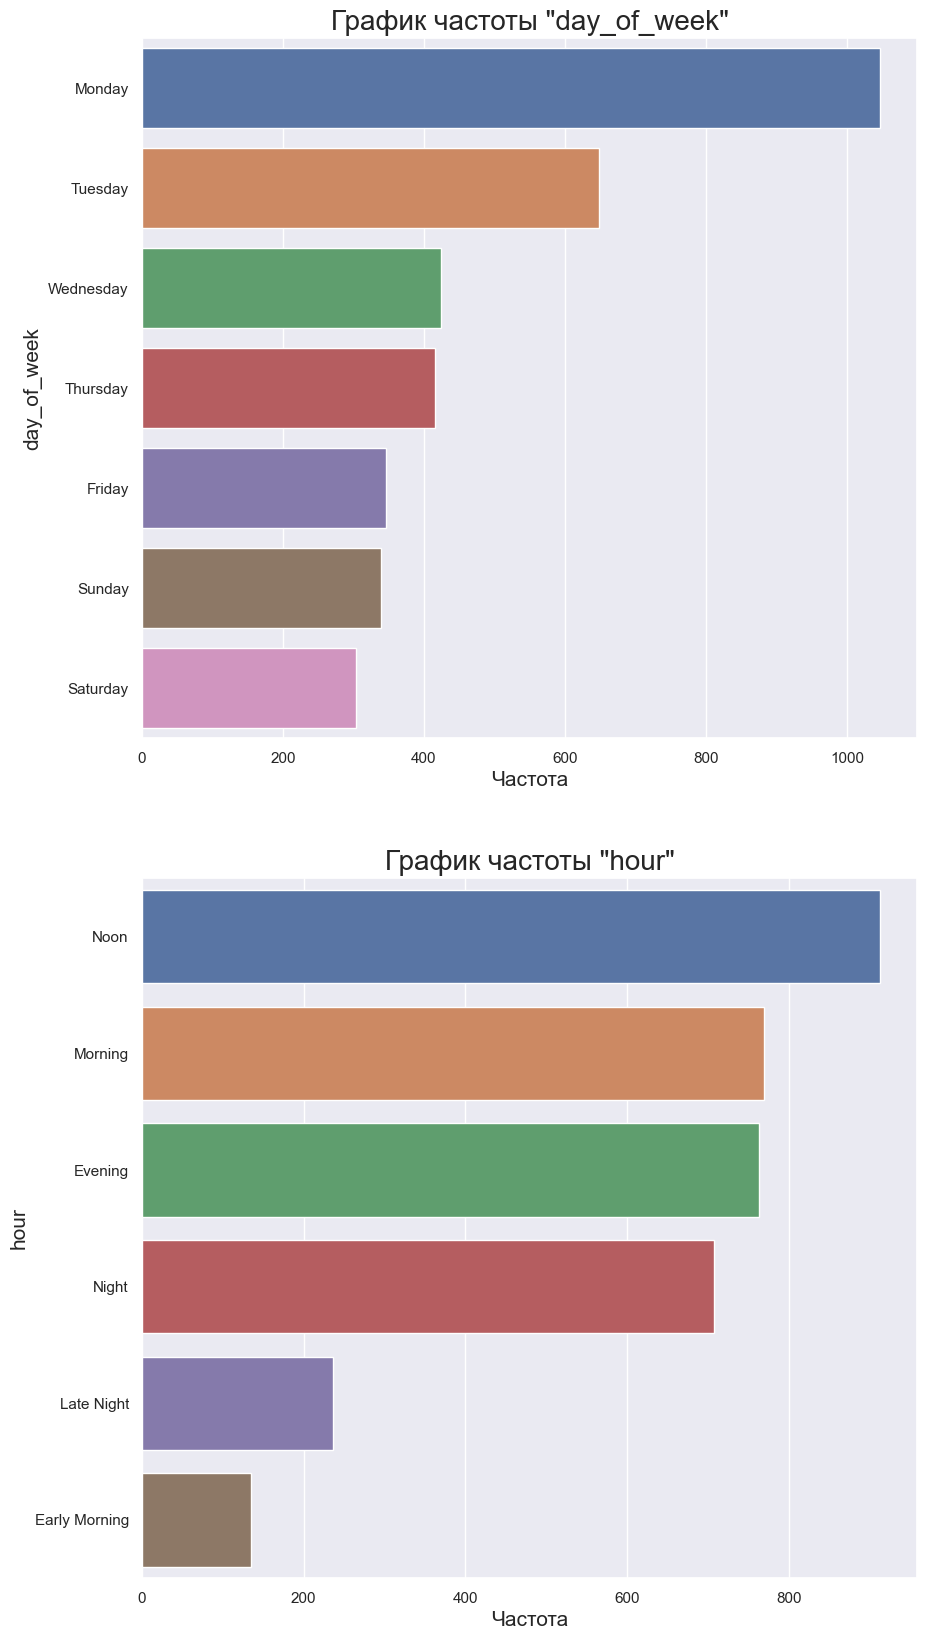

In [39]:
bar_plot_t(['day_of_week', 'hour'])

**Некоторые выводы:**
у нас есть наиболее частые метки времени для каждого пользователя. По ним можно группировать.

##### answer_id 
почему повторяются answer_id?

In [40]:
answers_df['answer_id'].value_counts()[answers_df['answer_id'].value_counts()<2]

09d61d7c-f933-425a-9141-e29df7832af7    1
e6a2f48f-252a-48a0-81ff-22f1415a8d7f    1
f68f995a-958f-4b33-b99b-2bdf7124139b    1
89b5ba4d-f91b-4482-99b8-e1ab320dc509    1
bb16a101-1fb6-4d8f-a09e-e3ff98cc84c8    1
                                       ..
73b4fe23-7173-479c-8d44-a8ed2a2dea79    1
ad685558-f451-4d81-8894-f12347f5850c    1
b51a27b2-3790-4404-8775-010188c5e416    1
608109bb-5c45-412e-b05d-1c48d9fe6667    1
f5932ca2-bd90-4952-a679-91107c6bc9e6    1
Name: answer_id, Length: 3754, dtype: int64

In [41]:
# Пример для ид ответа '22f30f57-992d-43f2-8b7f-e65076eeb551'
answers_df.loc[answers_df['answer_id']=='22f30f57-992d-43f2-8b7f-e65076eeb551']

,user_id,answer_date,answer_id,cohort,current_cohort,current_segment,original_segment,profession_name,question_title,question_type,user_answer,day_of_week,hour
32238,14786893,2023-07-05,22f30f57-992d-43f2-8b7f-e65076eeb551,data_cohort_115,data_cohort_117,b2g,b2g,data-analyst,"Для программы важно понять над чем вам нужно поработать. Не переживайте, вам будут доступны все опции.",checkbox,персональная карьерная консультация,Wednesday,Night
32240,14786893,2023-07-05,22f30f57-992d-43f2-8b7f-e65076eeb551,data_cohort_115,data_cohort_117,b2g,b2g,data-analyst,"Для программы важно понять над чем вам нужно поработать. Не переживайте, вам будут доступны все опции.",checkbox,решение тестовых заданий,Wednesday,Night
32241,14786893,2023-07-05,22f30f57-992d-43f2-8b7f-e65076eeb551,data_cohort_115,data_cohort_117,b2g,b2g,data-analyst,"Для программы важно понять над чем вам нужно поработать. Не переживайте, вам будут доступны все опции.",checkbox,оценка шансов на трудоустройство,Wednesday,Night
32243,14786893,2023-07-05,22f30f57-992d-43f2-8b7f-e65076eeb551,data_cohort_115,data_cohort_117,b2g,b2g,data-analyst,"Для программы важно понять над чем вам нужно поработать. Не переживайте, вам будут доступны все опции.",checkbox,определение стратегии поиска работы,Wednesday,Night
32245,14786893,2023-07-05,22f30f57-992d-43f2-8b7f-e65076eeb551,data_cohort_115,data_cohort_117,b2g,b2g,data-analyst,"Для программы важно понять над чем вам нужно поработать. Не переживайте, вам будут доступны все опции.",checkbox,сопроводительное письмо,Wednesday,Night
32248,14786893,2023-07-05,22f30f57-992d-43f2-8b7f-e65076eeb551,data_cohort_115,data_cohort_117,b2g,b2g,data-analyst,"Для программы важно понять над чем вам нужно поработать. Не переживайте, вам будут доступны все опции.",checkbox,оформление портфолио,Wednesday,Night


checkbox - поэтому и повторы, множественный выбор

##### current_segment	и original_segment


In [42]:
# Сравнение изменений по сегментам
# Таблица со всеми сегментами для каждого студента
segments_users = answers_df.groupby('user_id').agg({'current_segment':('first','last'),
                                                    'original_segment':('first','last')}).set_axis(['cur_segm_first',
                                                                                                    'cur_segm_last',
                                                                                                    'orig_segm_first',
                                                                                                    'orig_segm_last'],
                                                                                                    axis=1,
                                                                                                    inplace=False).reset_index()
segments_users

,user_id,cur_segm_first,cur_segm_last,orig_segm_first,orig_segm_last
0,3157,b2g,b2g,b2g,b2g
1,5415,b2g,b2g,b2g,b2g
2,8199,b2c,b2c,b2c,b2c
3,8215,b2c,b2c,b2c,b2c
4,10202,b2g,b2g,b2g,b2g
...,...,...,...,...,...
3519,16224921,b2c,b2c,b2c,b2c
3520,16230604,b2c,b2c,b2c,b2c
3521,16271708,b2c,b2c,b2c,b2c
3522,16501153,b2c,b2c,b2c,b2c


Поставим метки для тех, кто сменил сегмент

In [43]:
segments_users['is_segment_changed'] = np.where(((segments_users['cur_segm_first']==segments_users['cur_segm_last'])\
                                                 &(segments_users['orig_segm_first']==segments_users['orig_segm_last'])\
                                                 &(segments_users['cur_segm_first']==segments_users['orig_segm_first'])), 0, 1)
segments_users

,user_id,cur_segm_first,cur_segm_last,orig_segm_first,orig_segm_last,is_segment_changed
0,3157,b2g,b2g,b2g,b2g,0
1,5415,b2g,b2g,b2g,b2g,0
2,8199,b2c,b2c,b2c,b2c,0
3,8215,b2c,b2c,b2c,b2c,0
4,10202,b2g,b2g,b2g,b2g,0
...,...,...,...,...,...,...
3519,16224921,b2c,b2c,b2c,b2c,0
3520,16230604,b2c,b2c,b2c,b2c,0
3521,16271708,b2c,b2c,b2c,b2c,0
3522,16501153,b2c,b2c,b2c,b2c,0


Есть пользователи, которые меняли сегмент.  
Для дальнейшего анализа нам важен текущий последний сегмент и факт его смены. Поэтому оставим в таблице segments_users только `cur_segm_last` и `is_segment_changed`

In [44]:
segments_users = segments_users[['user_id', 'cur_segm_last' , 'is_segment_changed']]
segments_users

,user_id,cur_segm_last,is_segment_changed
0,3157,b2g,0
1,5415,b2g,0
2,8199,b2c,0
3,8215,b2c,0
4,10202,b2g,0
...,...,...,...
3519,16224921,b2c,0
3520,16230604,b2c,0
3521,16271708,b2c,0
3522,16501153,b2c,0


In [45]:
def pie_cat(df, category, value, name): 
    temp_df = df.pivot_table(index = category, values = value, aggfunc = 'count')
    temp_df.plot.pie(y=value, figsize=(10, 10), autopct="%.1f%%")
    plt.title('Доля {} в общем объеме выборки'.format(name))

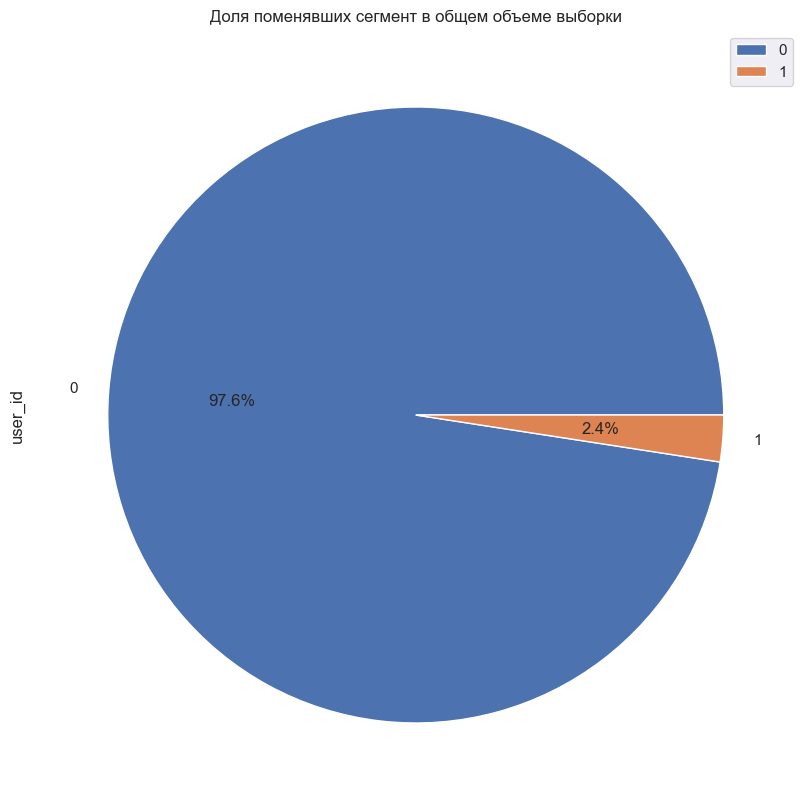

In [46]:
pie_cat(segments_users, 'is_segment_changed', 'user_id', 'поменявших сегмент')
plt.savefig('pie_1.svg', format = 'svg')


97% пользователей сегмент все же не меняли.

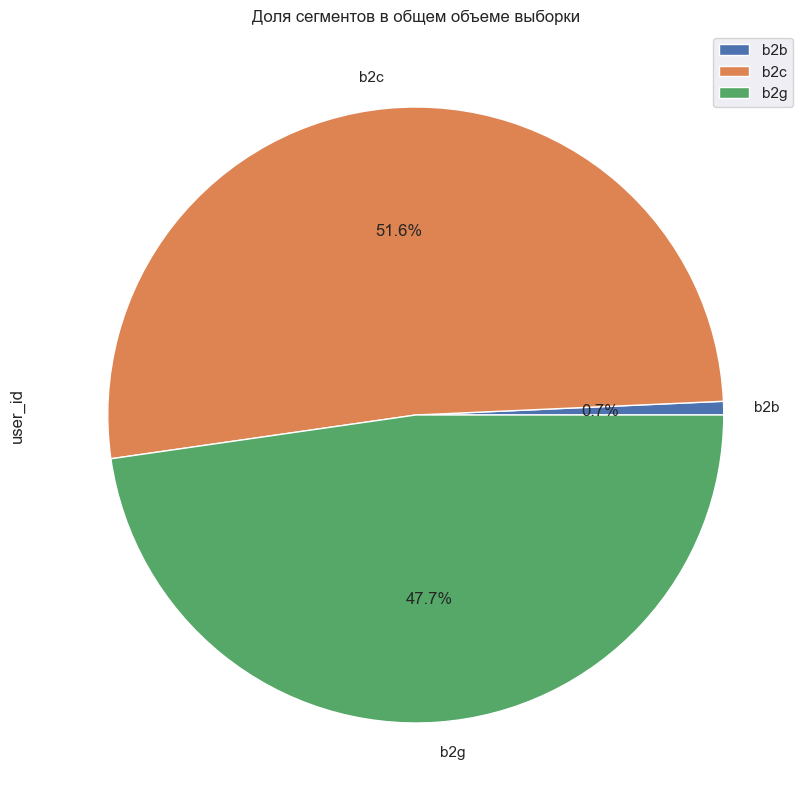

In [47]:
pie_cat(segments_users, 'cur_segm_last', 'user_id', 'сегментов')
plt.savefig('pie_2.svg', format = 'svg')

Большинство клиентов в выборке пришли сами, еще почти половина - через "Цифровые профессии", корпоративных клиентов мало.

##### profession_name	

In [48]:
answers_df['profession_name'].unique()

array(['data-analyst', 'data-scientist', 'data-analyst-plus',
       'systems-analyst', 'data-scientist-plus', 'sql-data-analyst',
       'data-engineer', 'datavis-and-bi-tools', 'data-science-bootcamp',
       'math-for-da-ds', 'data-analyst-bootcamp'], dtype=object)

Ниже (часть в разделе Сегментация студентов по профессиям) будет проведен анализ по профессиям студентов. Профессии будут укрупнены до блоков анализа данных, data science и прочие профессии.

In [49]:
# Сравнение изменений по когортам
# Таблица со всеми когортами для каждого студента 	
cohort_users = answers_df.groupby('user_id').agg({'cohort':('first','last'),
                                                 'current_cohort':('first','last')}).set_axis(['cur_coh_first',
                                                                                                    'cur_coh_last',
                                                                                                    'orig_coh_first',
                                                                                                    'orig_coh_last'],
                                                                                                    axis=1,
                                                                                                    inplace=False).reset_index()

cohort_users['is_cohort_changed'] = np.where(((cohort_users['cur_coh_first']==cohort_users['cur_coh_last'])\
                                                 &(cohort_users['orig_coh_first']==cohort_users['orig_coh_last'])\
                                                 &(cohort_users['cur_coh_first']==cohort_users['orig_coh_first'])), 0, 1)

cohort_users = cohort_users[['user_id','is_cohort_changed']]
cohort_users

,user_id,is_cohort_changed
0,3157,0
1,5415,1
2,8199,0
3,8215,0
4,10202,0
...,...,...
3519,16224921,0
3520,16230604,0
3521,16271708,0
3522,16501153,0


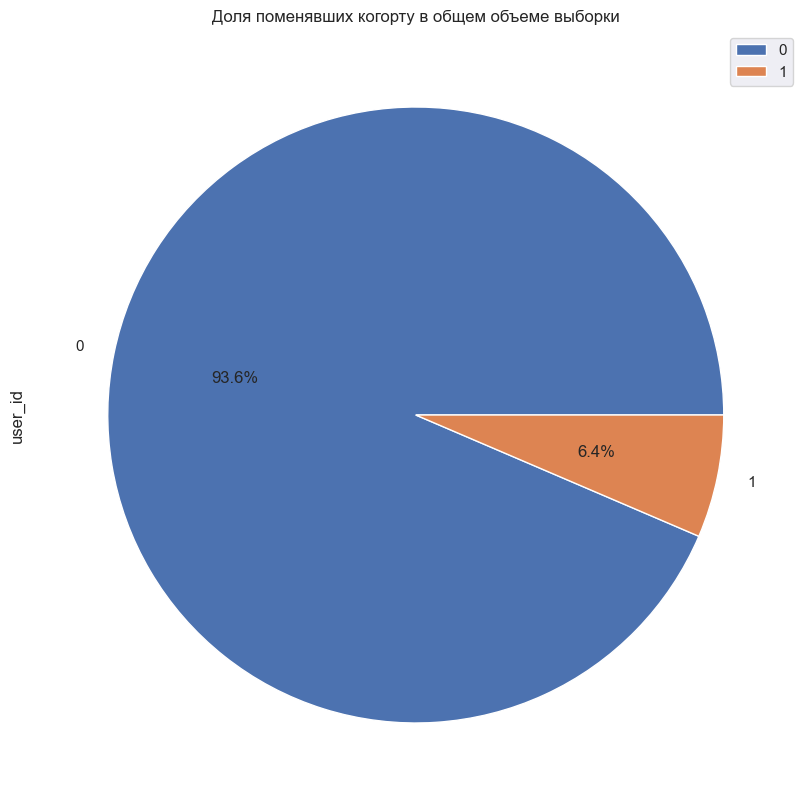

In [50]:
pie_cat(cohort_users, 'is_cohort_changed', 'user_id', 'поменявших когорту')

93% пользователей не меняли когорту во время обучения

##### question_title	и question_type	


In [51]:
# Соответствие вопросов, типов и ответов
answers_df.groupby(['question_title']).agg({'question_type':['unique','nunique'], 'user_answer':['unique','nunique']})

question_type  \
                                                                                                                                                                                                                                                                           unique   
question_title                                                                                                                                                                                                                                                                      
Бывает, что во время обучения меняется его цель. Например, изначально вы не планировали менять работу, но влюбились в профессию. Может, произошли жизненные изменения или вам сложно определить цель. Чтобы мы поняли, как помочь, отметьте подходящее утверждение:  [radio]        
В зависимости от опыта работы вам может понадобиться разный вид консультаций и помощи от команды сопровождения и трудоустройства. Для нас очень важен честный ответ и понимание вашего бэкграунда.                                                                   [radio]        
Возможно вы нашли работу за время обучения?                                                                                                                                                                                                                          [radio]        
Для программы важно понять над чем вам нужно поработать. Не переживайте, вам будут доступны все опции.                                                                                                                                                               [checkbox]     
Планируете ли вы записаться на Карьерный Трек?                                                                                                                                                                                                                       [radio]        
Тут вы можете оставить свой комментарий, если не нашли подходящего варианта ответа.                                                                                                                                                                                  [text]         

                                                                                                                                                                                                                                                                             \
                                                                                                                                                                                                                                                                    nunique   
question_title                                                                                                                                                                                                                                                                
Бывает, что во время обучения меняется его цель. Например, изначально вы не планировали менять работу, но влюбились в профессию. Может, произошли жизненные изменения или вам сложно определить цель. Чтобы мы поняли, как помочь, отметьте подходящее утверждение:  1        
В зависимости от опыта работы вам может понадобиться разный вид консультаций и помощи от команды сопровождения и трудоустройства. Для нас очень важен честный ответ и понимание вашего бэкграунда.                                                                   1        
Возможно вы нашли работу за время обучения?                                                                                                                                                                                                                          1        
Для программы важно понять над чем вам нужно поработать. Не переживайте, вам будут доступны все опции.                                      

У каждого вопроса только один тип. Наибольшее количество уникальных разных ответов встречается в вопросе с текстовым ответом.

##### user_answer

In [52]:
# В отдельной переменной сохраним series c текстовыми ответами, попробуем найти закономерности 
text_ans = answers_df.loc[answers_df['question_title']=="Тут вы можете оставить свой комментарий, если не нашли подходящего варианта ответа."]['user_answer']

In [53]:
answers_df['user_answer'].value_counts()

Нет                                                                         2734
резюме                                                                      2679
оформление портфолио                                                        2595
прохождение собеседований                                                   2578
решение тестовых заданий                                                    2429
                                                                            ... 
Нужно будет брать академ и проходить этот момент ещё раз                    1   
M                                                                           1   
Пока карьерный трек мне не нужен, но я запишусь после дипломного проекта    1   
Пока спросить нечего.                                                       1   
Не берут без опыта работы                                                   1   
Name: user_answer, Length: 1095, dtype: int64

In [54]:
answers_df['user_answer'].value_counts().head(20)

Нет                                                      2734
резюме                                                   2679
оформление портфолио                                     2595
прохождение собеседований                                2578
решение тестовых заданий                                 2429
сопроводительное письмо                                  2426
определение стратегии поиска работы                      2304
Сменить работу.                                          2301
оценка шансов на трудоустройство                         2241
Нет опыта работы в IT и в направлении Анализа данных.    2240
персональная карьерная консультация                      1946
Да, планирую записаться после диплома                    1930
устройство рынка труда                                   1742
как и куда можно расти как специалисту                   1725
определение профессиональной сферы                       1652
Да, уже записался                                        1286
как гово

То есть среди топ-20 ответов на доп. вопросы лидируют ответы по блокам:
* составление артефактов, стратегии
* собеседования/консультации
* оценка рынка труда/куда расти
* помощь с трудоустройством/смена работы
* что-то про личные мотивы (например, как говорить про повышение)

In [55]:
# Сколько уникальных ответов на каждый вопрос было получено от каждого студента
answers_df.pivot_table(values='user_answer', index='user_id', 
                       columns='question_title', 
                       aggfunc='nunique').sort_values(by="Для программы важно понять над чем вам нужно поработать. Не переживайте, вам будут доступны все опции.", ascending=False)

question_title,"Бывает, что во время обучения меняется его цель. Например, изначально вы не планировали менять работу, но влюбились в профессию. Может, произошли жизненные изменения или вам сложно определить цель. Чтобы мы поняли, как помочь, отметьте подходящее утверждение:",В зависимости от опыта работы вам может понадобиться разный вид консультаций и помощи от команды сопровождения и трудоустройства. Для нас очень важен честный ответ и понимание вашего бэкграунда.,Возможно вы нашли работу за время обучения?,"Для программы важно понять над чем вам нужно поработать. Не переживайте, вам будут доступны все опции.",Планируете ли вы записаться на Карьерный Трек?,"Тут вы можете оставить свой комментарий, если не нашли подходящего варианта ответа."
user_id,,,,,,
14655557,1.0,1.0,1.0,13.0,1.0,1.0
85866,1.0,1.0,1.0,13.0,1.0,1.0
14453879,1.0,1.0,1.0,13.0,1.0,1.0
14999881,1.0,1.0,1.0,13.0,1.0,1.0
12374034,1.0,1.0,1.0,13.0,1.0,1.0
...,...,...,...,...,...,...
15579587,NaN,1.0,NaN,NaN,NaN,NaN
15629755,NaN,1.0,NaN,NaN,NaN,NaN
15630621,NaN,1.0,NaN,NaN,NaN,NaN


Текст вопросов очень длинный. Заменим его на более короткий.  


In [56]:
dict_questions = {"Бывает, что во время обучения меняется его цель. Например, изначально вы не планировали менять работу, но влюбились в профессию. Может, произошли жизненные изменения или вам сложно определить цель. Чтобы мы поняли, как помочь, отметьте подходящее утверждение:":"цель", 
"В зависимости от опыта работы вам может понадобиться разный вид консультаций и помощи от команды сопровождения и трудоустройства. Для нас очень важен честный ответ и понимание вашего бэкграунда.":"опыт", 	
"Возможно вы нашли работу за время обучения?"	: "нашёл работу?", 	
"Для программы важно понять над чем вам нужно поработать. Не переживайте, вам будут доступны все опции.":"над чем поработать", 	 
"Планируете ли вы записаться на Карьерный Трек?":"планы на трек", 	 	 
"Тут вы можете оставить свой комментарий, если не нашли подходящего варианта ответа.":"комментарии",}

answers_df['question_title'] = answers_df['question_title'].replace(dict_questions)

### Сформулируем основные цели для студентов

1. Продвинуться по карьерной лестнице.
2. Сменить работу.
3. Развить свой бизнес.
4. Структурировать уже полученные навыки и знания.
5. Получить новые навыки для общего развития.
6. Получить новые знания, чтобы повысить зарплату.
7. Нет определённой цели в обучении.

Посмотрим на тексты зашитых ответов для каждого вопроса, кроме свободного

In [57]:
for q in answers_df.query('question_title!="комментарии"')['question_title'].unique():
  print("--"*10)
  print(q)
  print("--"*10)
  for ans in answers_df.query('question_title==@q')['user_answer'].unique():
    print(ans)

--------------------
над чем поработать
--------------------
определение профессиональной сферы
персональная карьерная консультация
устройство рынка труда
как и куда можно расти как специалисту
сопроводительное письмо
резюме
решение тестовых заданий
оценка шансов на трудоустройство
определение стратегии поиска работы
прохождение собеседований
оформление портфолио
как говорить про повышение
не думаю, что вы можете мне с чем-то помочь
--------------------
цель
--------------------
Продвинуться по карьерной лестнице.
Сменить работу.
Развить свой бизнес. 
Структурировать уже полученные навыки и знания.
Получить новые навыки для общего развития.
Получить новые знания, чтобы повысить зарплату.
Нет определённой цели в обучении.
--------------------
нашёл работу?
--------------------
Да
Нет
В активном поиске
--------------------
опыт
--------------------
Нет опыта работы в IT и в направлении Анализа данных.
От 1 года опыта работы в другом направлении IT.
Более 3 лет опыта работы в направлении 

In [58]:
def bar_plot_q (list_of_param):
  
  fig, axes = plt.subplots(len(list_of_param), figsize=(10, len(list_of_param)*10))

  for i, q in zip(range(len(list_of_param)), list_of_param):
    temp_df = answers_df[answers_df['question_title'] == q].pivot_table(index = 'user_answer', 
                                                          values = 'user_id', 
                                                          aggfunc = 'count').sort_values(by='user_id',
                                                                                         ascending = False)
    temp_df = temp_df.reset_index()
    sns.barplot(ax = axes[i], data = temp_df, y = 'user_answer', x = 'user_id')
    axes[i].set_title('График частоты вариантов ответа на вопрос "{}"'.format(q), fontsize=20)
    axes[i].set_ylabel('Варианты ответов', fontsize=15)
    axes[i].set_xlabel('Частота', fontsize=15)

In [59]:
for i, q in zip(range(len(list(answers_df.query('question_title!="комментарии"')['question_title'].unique()))), 
                list(answers_df.query('question_title!="комментарии"')['question_title'].unique())):
    temp_df = answers_df[answers_df['question_title'] == q].pivot_table(index = 'user_answer', 
                                                          values = 'user_id', 
                                                          aggfunc = 'count').sort_values(by='user_id',
                                                                                         ascending = False)
    display (temp_df)
    print ('---------')

,user_id
user_answer,
резюме,2679
оформление портфолио,2595
прохождение собеседований,2578
решение тестовых заданий,2429
сопроводительное письмо,2426
определение стратегии поиска работы,2304
оценка шансов на трудоустройство,2241
персональная карьерная консультация,1946
устройство рынка труда,1742


---------


,user_id
user_answer,
Сменить работу.,2301
Получить новые навыки для общего развития.,372
"Получить новые знания, чтобы повысить зарплату.",346
Продвинуться по карьерной лестнице.,215
Структурировать уже полученные навыки и знания.,172
Нет определённой цели в обучении.,61
Развить свой бизнес.,40


---------


,user_id
user_answer,
Нет,2700
В активном поиске,568
Да,202


---------


,user_id
user_answer,
Нет опыта работы в IT и в направлении Анализа данных.,2240
От 1 года опыта работы в другом направлении IT.,494
От 1 до 3 лет опыта работы направлении Анализа данных.,176
Более 3 лет опыта работы в направлении Анализа данных.,154
Менее 1 года опыта работы в другом направлении IT.,141
Менее года опыта работы в направлении Анализа данных.,126
Нет опыта работы аналитиком и в IT.,83
От 1 до 3 лет опыта работы аналитиком.,48
Более 3 лет опыта работы аналитиком.,27


---------


,user_id
user_answer,
"Да, планирую записаться после диплома",1930
"Да, уже записался",1286
"Нет, не планирую",291


---------


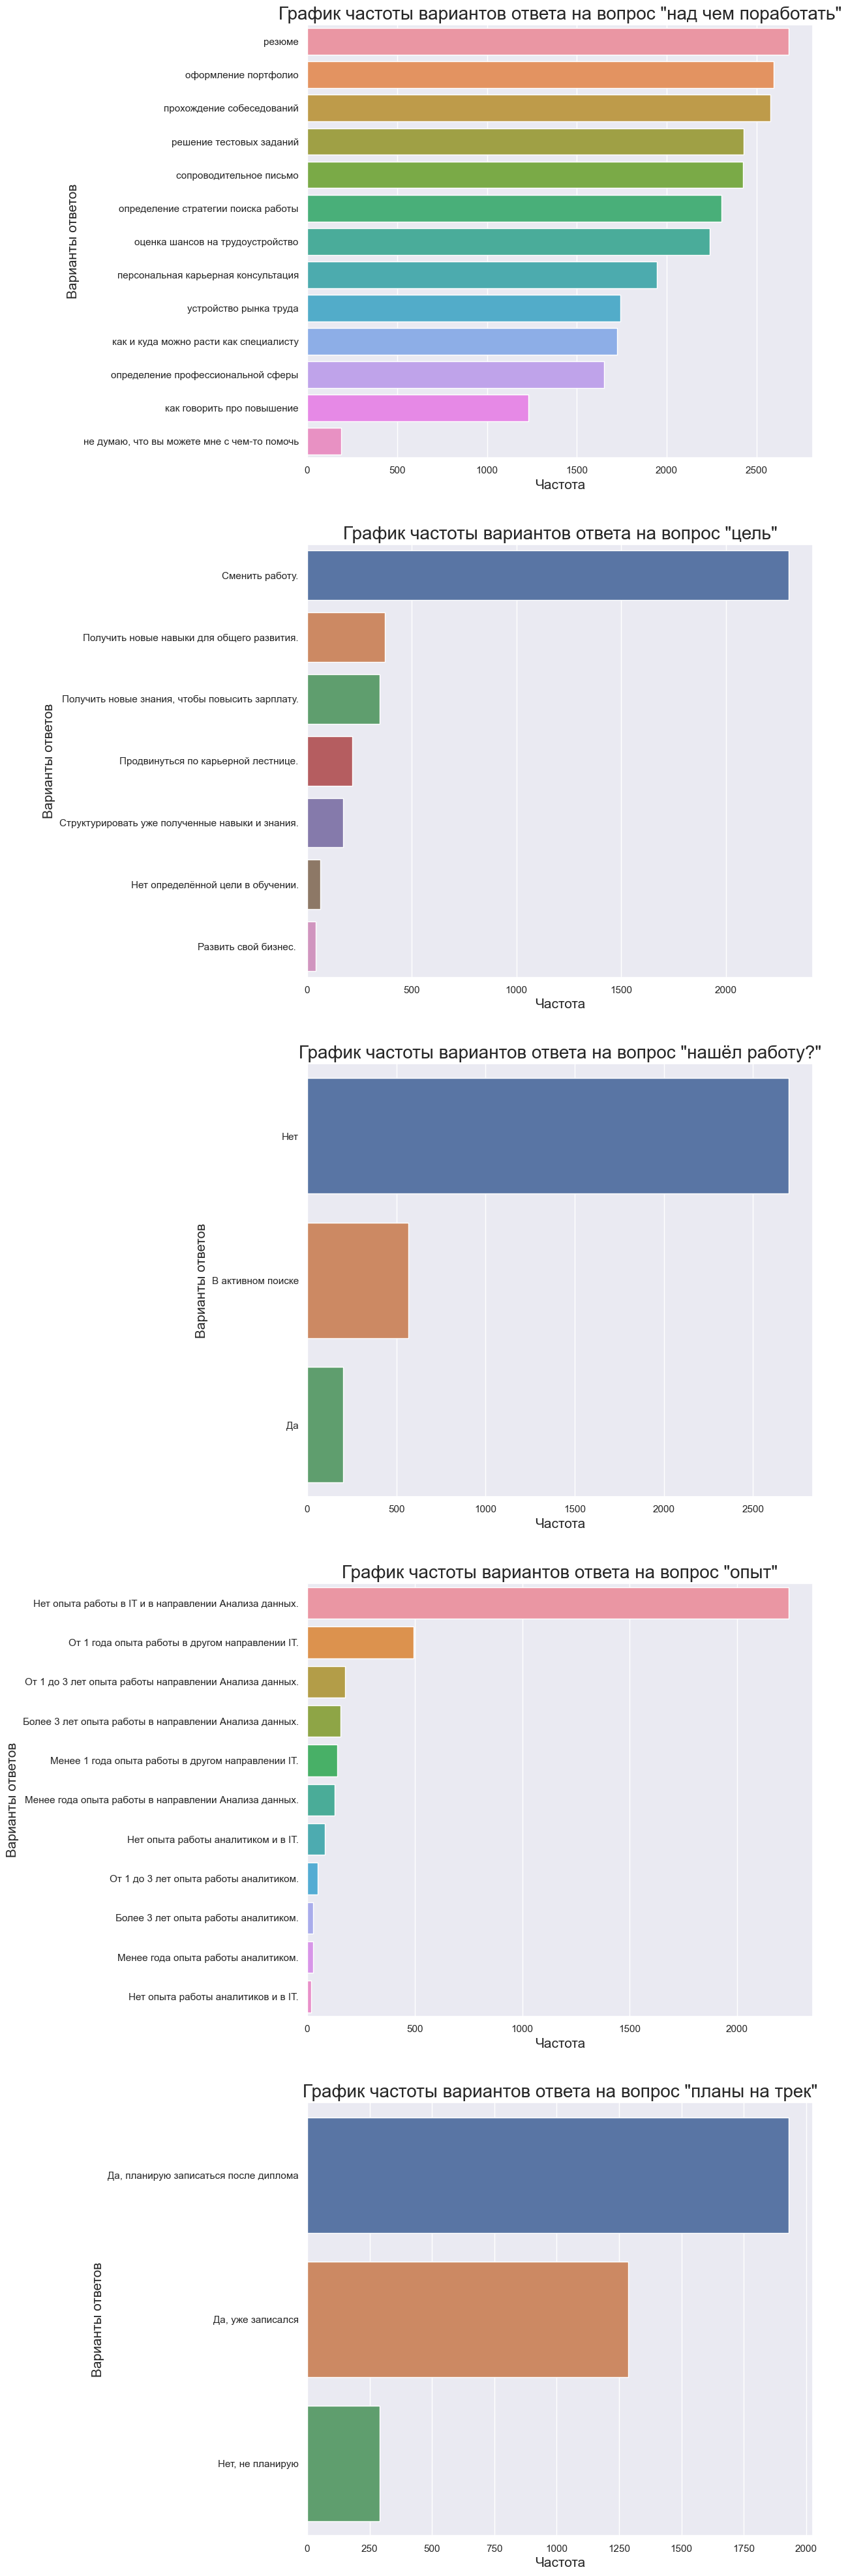

In [60]:
bar_plot_q(list(answers_df.query('question_title!="комментарии"')['question_title'].unique()))
plt.savefig('plot_1.svg', format = 'svg')

Заменим одинаковые по смыслу ответы в вопросе про опыт, т.к. есть неявные дубли  и длинные ответы


In [61]:
dict_expier_ans = {"Нет опыта работы в IT и в направлении Анализа данных.":"Нет опыта", 
                   "Нет опыта работы аналитиком и в IT.":"Нет опыта",
                   "Нет опыта работы аналитиков и в IT.":"Нет опыта", 
                   "Более 3 лет опыта работы в направлении Анализа данных.":"Более 3 лет опыта",
                    "Более 3 лет опыта работы аналитиком.":"Более 3 лет опыта", 
                   "От 1 до 3 лет опыта работы направлении Анализа данных.": "От 1 до 3 лет аналитиком?",
                    "От 1 до 3 лет опыта работы аналитиком.": "От 1 до 3 лет аналитиком?",
                   "От 1 года опыта работы в другом направлении IT.":"От 1 года опыта др.", 
                   "Менее года опыта работы в направлении Анализа данных.":"Менее года в аналитике", 
                    "Менее года опыта работы аналитиком.":"Менее года в аналитике",
                   "Менее 1 года опыта работы в другом направлении IT.":"Менее 1 года опыта др.",
                   
                   "определение профессиональной сферы":"профориентация",
"персональная карьерная консультация":"персональная консультация",
"как и куда можно расти как специалисту":"куда расти",
"сопроводительное письмо":"сопроводительное",
"решение тестовых заданий":"тестовые",
"определение стратегии поиска работы":"стратегия поиска работы",
"прохождение собеседований":"собеседования",
"оформление портфолио":"портфолио",
"как говорить про повышение":"про повышение",
"не думаю, что вы можете мне с чем-то помочь":"практикум не сможет помочь",

"Да, планирую записаться после диплома":"да, план",
"Да, уже записался":"да, уже",
"Нет, не планирую":"нет",

"Продвинуться по карьерной лестнице.":"карьера",
"Развить свой бизнес. " :"бизнес",
"Структурировать уже полученные навыки и знания.":"структурировать знания",
"Получить новые навыки для общего развития.":"новые знания - общее развитие",
"Получить новые знания, чтобы повысить зарплату.":"новые знания - рост ЗП",
"Нет определённой цели в обучении.":"нет цели",
}

answers_df['user_answer'] = answers_df['user_answer'].replace(dict_expier_ans)

Добавляем столбцы с категориальными признаками 1 - студент ответил на этот вопрос этим ответом, 0 - не ответил  

In [62]:
# Список вопросов
questions_list = answers_df.query('question_title!="комментарии"')['question_title'].unique()

# Таблица ответов пользователей, без комментариев
users_answers = answers_df.query('question_title!="комментарии"').pivot_table(values='user_answer', 
                                                                              index='user_id',
                                                                              columns='question_title',
                                                                              aggfunc='last')

for col in users_answers.columns:
  users_answers = pd.concat([users_answers, pd.get_dummies(users_answers[col], prefix=col)], axis=1)

users_answers

,над чем поработать,нашёл работу?,опыт,планы на трек,цель,над чем поработать_куда расти,над чем поработать_оценка шансов на трудоустройство,над чем поработать_персональная консультация,над чем поработать_портфолио,над чем поработать_практикум не сможет помочь,...,"планы на трек_да, план","планы на трек_да, уже",планы на трек_нет,цель_Сменить работу.,цель_бизнес,цель_карьера,цель_нет цели,цель_новые знания - общее развитие,цель_новые знания - рост ЗП,цель_структурировать знания
user_id,,,,,,,,,,,,,,,,,,,,,
3157,тестовые,Да,Нет опыта,"да, план",карьера,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
5415,стратегия поиска работы,Нет,От 1 года опыта др.,"да, план",Сменить работу.,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
8199,портфолио,Нет,Нет опыта,"да, уже",Сменить работу.,0,0,0,1,0,...,0,1,0,1,0,0,0,0,0,0
8215,персональная консультация,Нет,Нет опыта,"да, план",Сменить работу.,0,0,1,0,0,...,1,0,0,1,0,0,0,0,0,0
10202,стратегия поиска работы,Нет,Более 3 лет опыта,"да, уже",бизнес,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16224921,сопроводительное,Нет,Нет опыта,нет,Сменить работу.,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
16230604,практикум не сможет помочь,Да,Менее года в аналитике,нет,новые знания - общее развитие,0,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0
16271708,оценка шансов на трудоустройство,В активном поиске,Нет опыта,"да, план",Сменить работу.,0,1,0,0,0,...,1,0,0,1,0,0,0,0,0,0


In [63]:
# Отдельная переменная для бинарных ответов на вопросы
users_answers_binary = users_answers.drop(columns=questions_list)

# Текстовые ответы в отдельную переменную
users_answers = users_answers[questions_list]

### Строим общую таблицу

In [64]:
# Группируем result_df по студенту
final_df = answers_df.groupby('user_id').agg({'answer_id':'nunique', 'profession_name':'last'}).reset_index()

#объединяем таблицы, оставляя только тех пользователей, кто есть в таблице answers
# Неибзежно теряя при этом часть данных (чуть больше 10%)
final_df = pd.merge(final_df, metrics_df_redone, on = 'user_id', how = 'left')

# Добавляем остальные показатели
for df in [users_time_mode, segments_users, cohort_users, users_answers_binary]:
  final_df = final_df.merge(df, on = 'user_id') 
final_df                                               

,user_id,answer_id,profession_name,last_perf_evaluation,is_perf_grow,mean_user_recommend_value,mean_value_statement_content,day_of_week,hour,cur_segm_last,...,"планы на трек_да, план","планы на трек_да, уже",планы на трек_нет,цель_Сменить работу.,цель_бизнес,цель_карьера,цель_нет цели,цель_новые знания - общее развитие,цель_новые знания - рост ЗП,цель_структурировать знания
0,3157,4,data-analyst,0.652,0.0,NaN,1.250,Friday,Morning,b2g,...,1,0,0,0,0,1,0,0,0,0
1,5415,4,data-analyst,0.850,1.0,NaN,0.000,Thursday,Noon,b2g,...,1,0,0,1,0,0,0,0,0,0
2,8199,4,data-analyst,0.711,0.0,NaN,-0.167,Saturday,Evening,b2c,...,0,1,0,1,0,0,0,0,0,0
3,8215,4,data-scientist,0.760,1.0,NaN,0.167,Tuesday,Night,b2c,...,1,0,0,1,0,0,0,0,0,0
4,10202,4,data-analyst-plus,0.712,0.0,NaN,0.500,Tuesday,Noon,b2g,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3519,16224921,4,sql-data-analyst,NaN,NaN,NaN,NaN,Tuesday,Evening,b2c,...,0,0,1,1,0,0,0,0,0,0
3520,16230604,4,sql-data-analyst,NaN,NaN,NaN,NaN,Saturday,Night,b2c,...,0,0,1,0,0,0,0,1,0,0
3521,16271708,4,sql-data-analyst,NaN,NaN,NaN,NaN,Sunday,Evening,b2c,...,1,0,0,1,0,0,0,0,0,0
3522,16501153,4,data-analyst,NaN,NaN,NaN,NaN,Monday,Noon,b2c,...,1,0,0,0,1,0,0,0,0,0


In [65]:
miss_table(final_df)

,% miss,# miss
user_id,0.000000,0
answer_id,0.000000,0
profession_name,0.000000,0
last_perf_evaluation,10.811578,381
is_perf_grow,10.811578,381
mean_user_recommend_value,84.875142,2991
mean_value_statement_content,10.811578,381
day_of_week,0.000000,0
hour,0.000000,0
cur_segm_last,0.000000,0


Есть пропуски - заменим медианной по профессиям, т.к. медиана меньше даст искажений, а по профессиям, потому что - это одна из основных и стабильных характеристик студентов - мало переходов среди них в другие

In [66]:
# Для каждой колонки с пропусками заменяем наны на медианное значение по этой колонке с учётом группировки по профессии
for column_with_nan in ['last_perf_evaluation','is_perf_grow','mean_value_statement_content']:
    for prof_type in final_df['profession_name'].unique():
        final_df[column_with_nan] = final_df[column_with_nan].fillna(final_df.groupby('profession_name')[column_with_nan].transform('median')) 
    
    display(f'Количество пропусков после их замены в столбце {column_with_nan}', final_df[column_with_nan].isna().sum())

'Количество пропусков после их замены в столбце last_perf_evaluation'

0

'Количество пропусков после их замены в столбце is_perf_grow'

0

'Количество пропусков после их замены в столбце mean_value_statement_content'

0

пропуски скорее всего там , где профессия datavis-and-bi-tools

In [67]:
final_df[final_df['profession_name']=="datavis-and-bi-tools"].index

Int64Index([  58,  144,  163,  174,  247,  269,  290,  350,  360,  520,  573,
             775,  929,  971, 2043, 2071, 2120, 2452, 2905, 3314, 3439, 3445,
            3450, 3480, 3482, 3506],
           dtype='int64')

да, это так. удалим их из final_df. Мы можем вернуться к изучению ответов студентов этой профессии потом, получив данные из final_df.

In [68]:
#final_df.drop(index=final_df[final_df['profession_name']=="datavis-and-bi-tools"].index, inplace=True)

In [69]:
miss_table(final_df)

,% miss,# miss
user_id,0.000000,0
answer_id,0.000000,0
profession_name,0.000000,0
last_perf_evaluation,0.000000,0
is_perf_grow,0.000000,0
mean_user_recommend_value,84.875142,2991
mean_value_statement_content,0.000000,0
day_of_week,0.000000,0
hour,0.000000,0
cur_segm_last,0.000000,0


In [70]:
final_df['mean_user_recommend_value'].value_counts(dropna=False)

NaN     2991
10.0    223 
8.0     98  
9.0     73  
7.0     56  
5.0     36  
6.0     17  
4.0     9   
3.0     7   
2.0     5   
0.0     4   
4.5     1   
6.5     1   
1.0     1   
7.5     1   
3.5     1   
Name: mean_user_recommend_value, dtype: int64

### Выводы:

На данном этапе мы провели исследовательский анализ данных. 
Рассмотрели, какие ответы наиболее характерны для студентов:

*Время и дата ответа* 

В понедельники и вторники больше всего ответов, чаще всего отвечают на вопросы днем;

*Дубликаты в ID*

есть несколько ответов на вопросы, например, на checkbox - множественный выбор; будем учитывать это в анализе;

*Сегмент студента*

Есть пользователи, которые меняли сегмент.
Для дальнейшего анализа нам важен текущий последний сегмент и факт его смены. 97% сегмент все же не меняли, большинство клиентов в выборке пришли сами, еще почти половина - через "Цифровые профессии", корпоративных клиентов мало.

*Профессии студентов*

Данные содержат информацию о студентах 11 профессий. Ниже (часть в разделе Сегментация студентов по профессиям) будет проведен анализ по профессиям студентов. Профессии будут укрупнены до блоков аналитиков данных, data science и прочие профессии;

*Когорты студентов*

93% пользователей не меняли когорту во время обучения;

*Типы ответов*

У каждого вопроса только один тип. Наибольшее количество уникальных разных ответов встречается в вопросе с текстовым ответом;

Среди топ-20 ответов на доп. вопросы лидируют ответы по блокам:

* составление артефактов, стратегии
* собеседования/консультации
* оценка рынка труда/куда расти
* помощь с трудоустройством/смена работы
* личные мотивы (например, как говорить про повышение)

Для дополнения исследования мы построили визуализации по наиболее частым ответам пользователей, а также сформировали таблицы пересечений между собой.

**Сформулировали основные цели для студентов**
* Продвинуться по карьерной лестнице.
* Сменить работу.
* Развить свой бизнес.
* Структурировать уже полученные навыки и знания.
* Получить новые навыки для общего развития.
* Получить новые знания, чтобы повысить зарплату.
* Нет определённой цели в обучении.

Также провели объединение таблиц с метриками и ответами по ID. 

## Портреты студентов


---



**Описание раздела:**

В данном разделе будет проведена группировка студентов с использованием сводных таблиц и хитмапов, а также с помощью кластеризации.

### Сводные таблицы и хитмапы по ответам на вопросы 

In [71]:
# Сделаем отдельную табличку для графиков, где вынесем id из индексов
users_answers_for_plot = users_answers.reset_index()

In [72]:
users_answers_for_plot.columns

Index(['user_id', 'над чем поработать', 'цель', 'нашёл работу?', 'опыт',
       'планы на трек'],
      dtype='object')

In [73]:
# y_value - это основная переменная, по которой мы прогоняем все хитмапы, например "цель обучения"
# x_value - это список столбцов по которым мы хотим получит хитмапы
# x_value - это именно список, одно значение давать не надо, крашится код
# В параметр df мы загоняем наш датафрейм без тех значений, что искривляют хитмап, например "Сменить работу"

def heatmap_for_target(df, y_value, x_value):
  fig, axes = plt.subplots(len(x_value), figsize=(20, 20*len(x_value)))

  for i, q in zip(range(len(x_value)), x_value):
    temp_df = df.pivot_table(index = y_value, 
                            values = 'user_id', 
                            columns = q,
                            aggfunc = 'count',
                             margins = True)
    #temp_df=(temp_df-temp_df.mean())/temp_df.std() # Один из вариантов нормализации
    for j in list(temp_df.columns):
      temp_df[j] = temp_df[j]/temp_df['All'] # Считаем проценты по строке
    
    temp_df.drop(columns = 'All', inplace = True)

    sns.heatmap(ax = axes[i], data = temp_df, annot=True, fmt='.0%', linewidths = 2, cmap = 'YlOrBr')
    axes[i].set_title('Хитмеп ответов пользователей на вопросы', fontsize=20)
    axes[i].set_ylabel(y_value, fontsize=15)
    axes[i].set_xlabel(q, fontsize=15)

Хитмапы сперва по всему датафрейму: чем больше значение, тем больше доля ответов студентов в этом пересечении

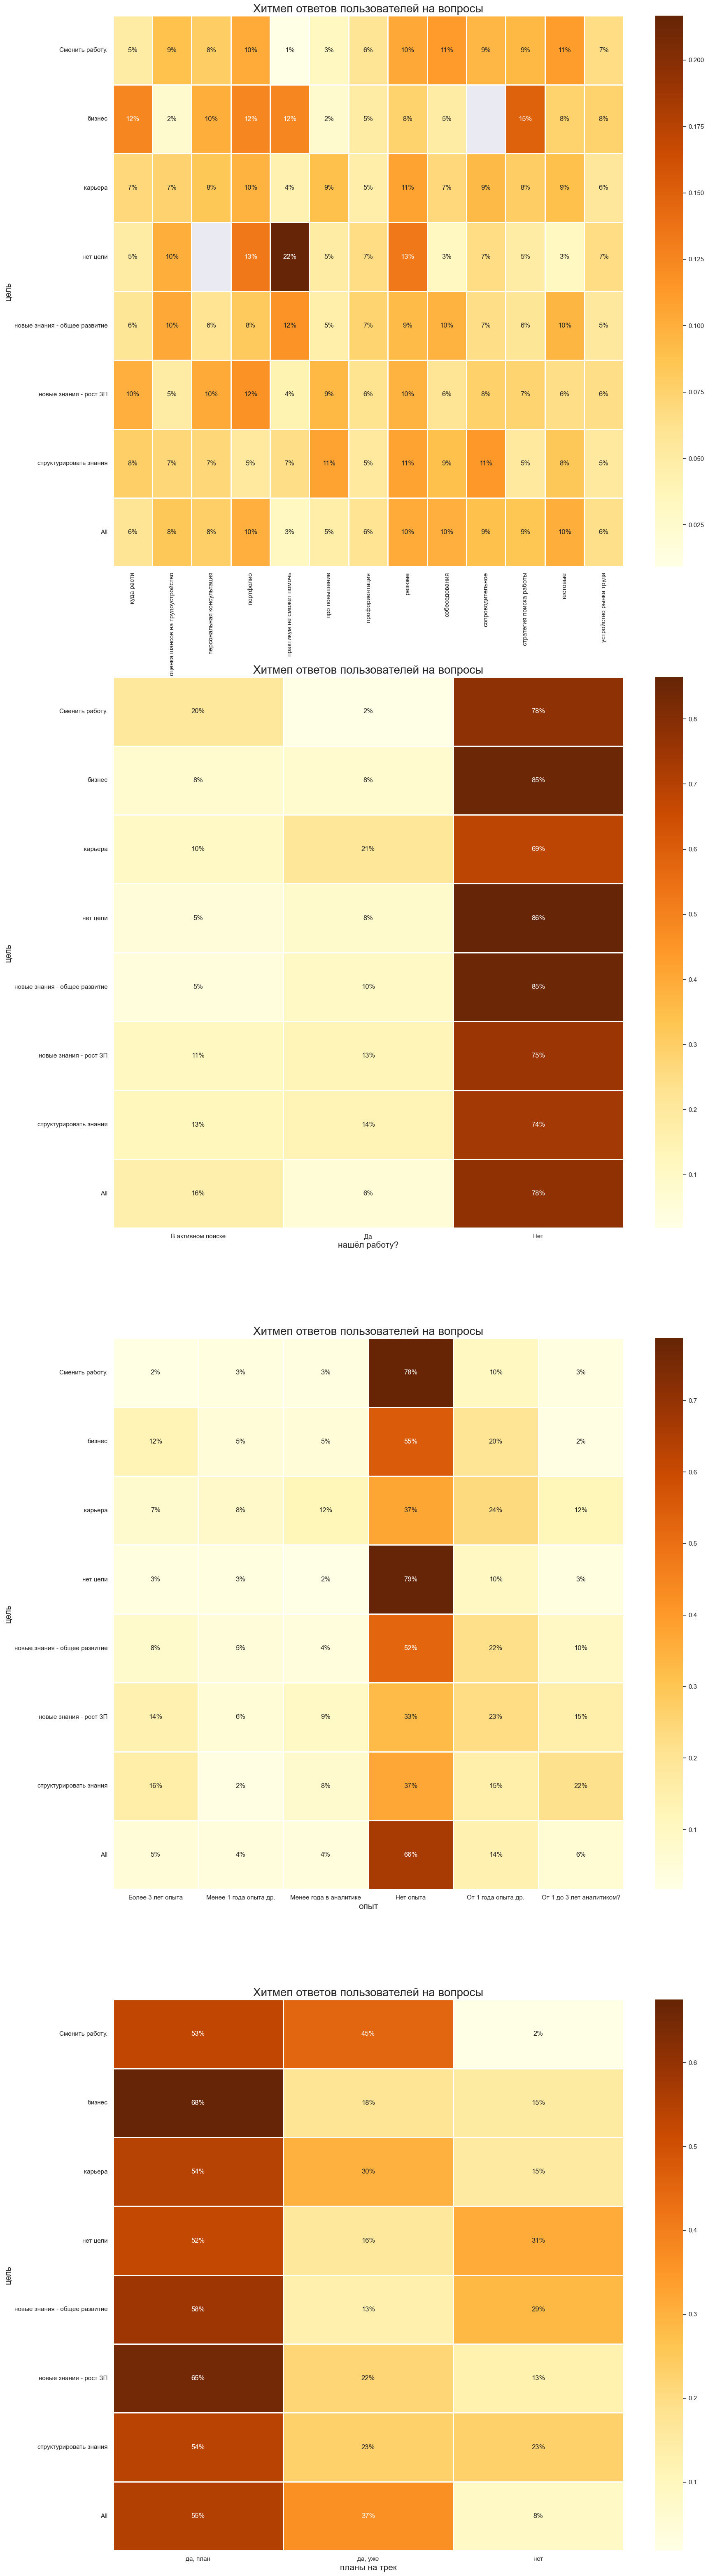

In [74]:
heatmap_for_target (df = users_answers_for_plot,
                    y_value = 'цель', 
                    x_value = ['над чем поработать','нашёл работу?', 'опыт', 'планы на трек'])

Мы построили хитмепы по пересечениям ответов на различные вопросы по целям, опыту, желанию пойти в карьерный трек, нахождению работы и тому, устроились ли они на работу в течение обучения.

Можно выделить, что основной целью для большинства студентов является смена работы - для таких пользователей характерно наибольшее количество пересечений, и среди того, над чем они хотят поработать выделяются потребность в собеседованиях, портфолио и решение тестовых.

Среди тех, кто хочет найти работу, в течение обучения работу найти пока не удалось. Или они находятся в стадии активного поиска.

Среди тех, кто хочет найти работу в основном превалируют люди без опыта.

И большинство пользователей, которые хотят сменить работу, имеют планы на карьерный трек: либо уже проходят его, либо сделают это после диплома.

**В данном хитмепе теряется наглядность для остальных факторов - наибольшее количество пользователей из когорты студентов без опыта и стремящихся сменить работу. Интересно посмотреть взаимосвязи без этих факторов.**

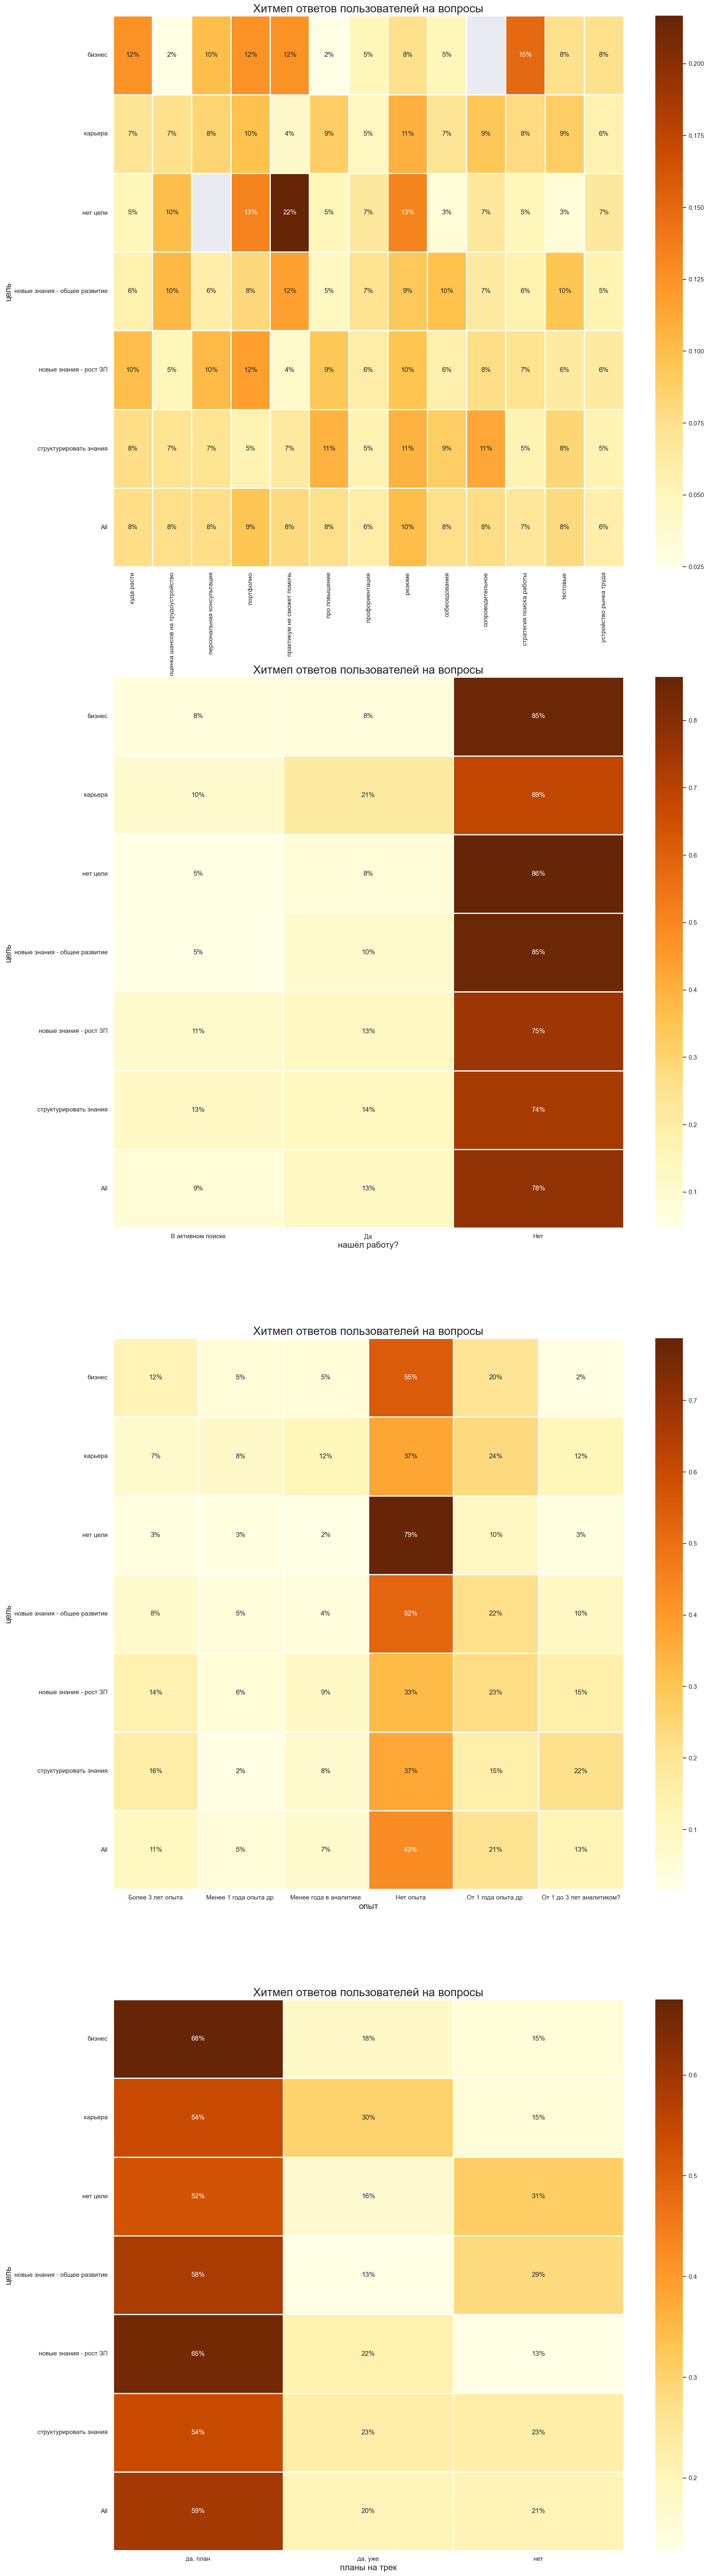

In [75]:
#Хитмап с ответами на вопросы без цели "Сменить работу"
heatmap_for_target (df = users_answers_for_plot[users_answers_for_plot['цель'] != 'Сменить работу.'],
                    y_value = 'цель', 
                    x_value = ['над чем поработать','нашёл работу?', 'опыт', 'планы на трек'])

Среди пользователей, которые выбрали основной целью не смену работы, превалирую те, кто стремятся к новым знаниям и общему развитию. При этом наибольшее количество пересечений между этим фактором и фактором невозможности практикума помочь по этой цели.

Также достаточно высоко находится цель получения новых знаний с точки зрения увеличения ЗП, и для этого фактора портфолио - это основной пункт, над чем хотят поработать студенты

Среди пользователей, которые нацелены на поиск новых знаний выделяются те, кто работу все еще на нашел.

Среди этих пользователей превалируют пользователи, которые опыта работы не имеют. 

И среди пользователей, которые нацелены на поиск новых знаний выделяются те, которые имеют планы на карьерный трек

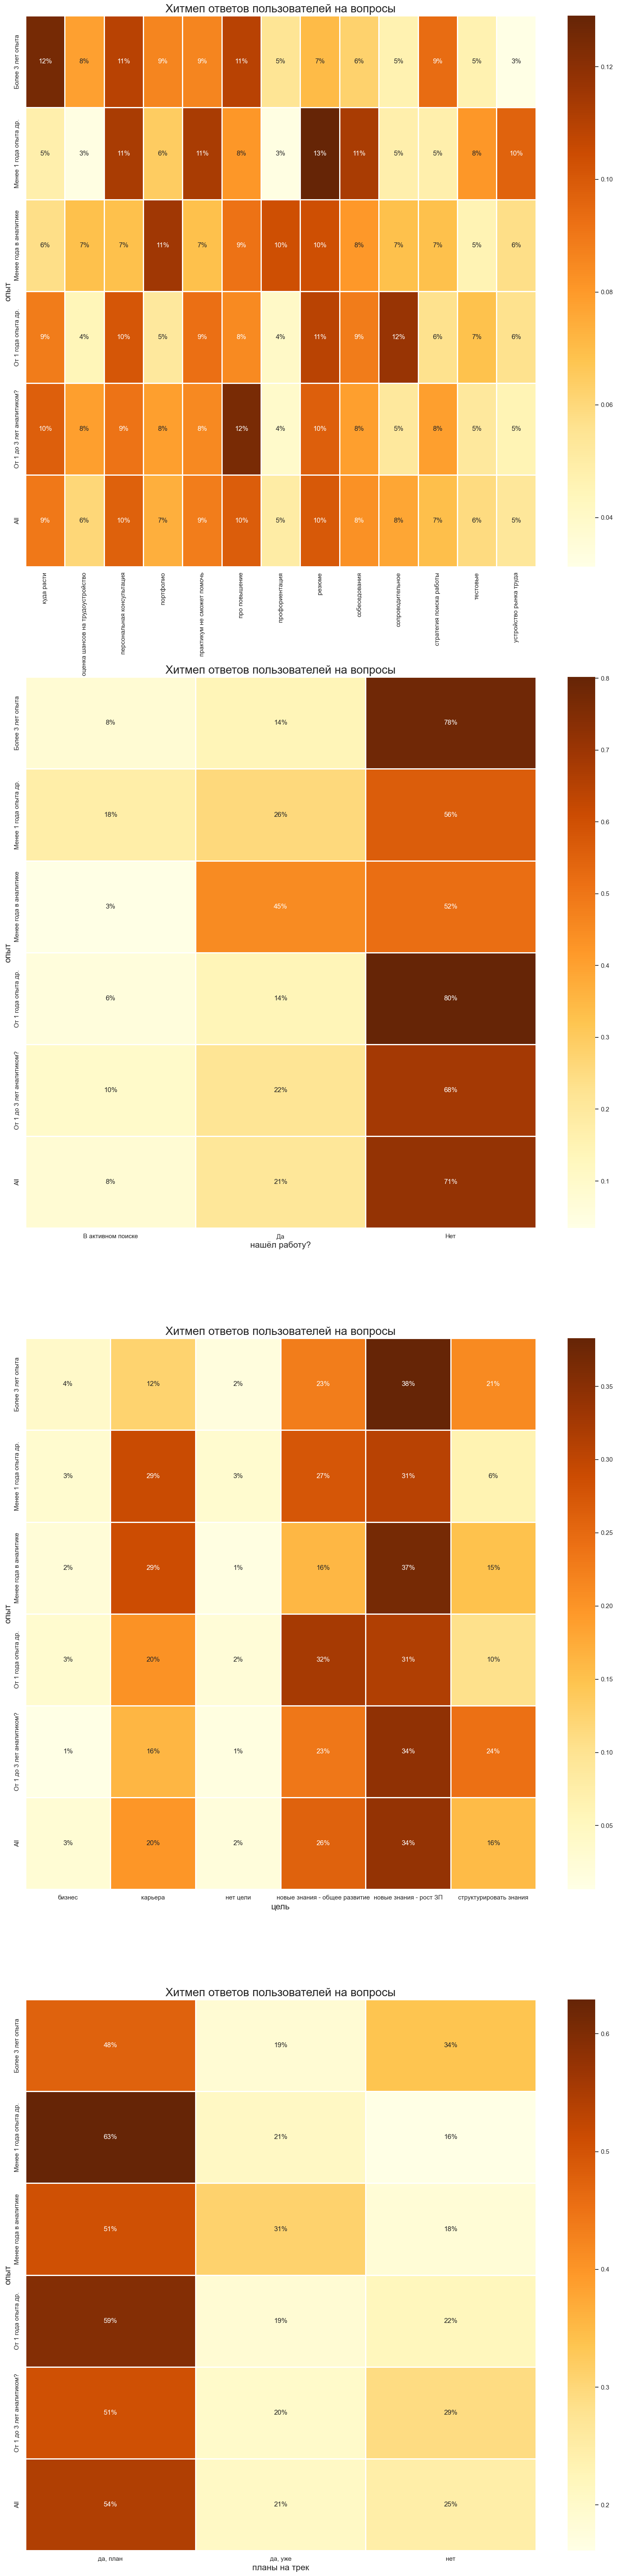

In [76]:
#Хитмап с ответами на вопросы без цели "Сменить работу" и опыта "Нет опыта"
heatmap_for_target (df = users_answers_for_plot[(users_answers_for_plot['цель'] != 'Сменить работу.') & (users_answers_for_plot['опыт'] != 'Нет опыта')],
                    y_value = 'опыт', 
                    x_value = ['над чем поработать','нашёл работу?', 'цель', 'планы на трек'])

**Некоторые выводы:**  

Мы убрали факторы "сменить работу" и "нет опыта", так как эти факторы оказывают наибольшее влияние на показатели (наибольшее количество пользователей попадают в эти группы)

А по прочим категориям пользователей:

**Опыт и цели**

* Среди взаимодействия между целями пользователя и опытом работы наибольшее значение имеют группы пользователелей с опытом работы от 1 года в другой сфере и с целями в составлении резюме, написании сопроводительных писем и карьерной консультацией. Можно предположить, что данная группа олицетворяет тех, кто осознанно подходит к процессу поиска работы и понимает, что для трудоустройства необходимы не только навыки и знания, но и так называмые "артефакты" в виде резюме, сопроводительного и портфолио.

* Среди этого хитмепа следующая группа - это аналитики с опытом от 1 до 3 лет, которые заинтересованы в изучении рынка и способов повышения в этой сфере (появляются цели в виде "как говорить про повышение" и "как расти как специалисту")

* Большинство пользователей в категории 1 год опыта работы в другой сфере практически одинаково сильно хотят узнать новые навыки для общего развития и при этом повысить свою зарплату. Большинство пользователей считает, что навыки работы с данными - это те самые новые навыки, которые могут привести к большей зарплате.

**Опыт и нашел ли работу**

* Большинство людей находятся в группе более 1 года опыта в другой сфере и при этом не нашли работу по направлению. Предполагаем, что большинство настроены в первую очередь закончить обучение и только потом заниматься активным поиском. Это также и подтверждается низким показателем активности поиска работы для всех категорий пользователей - большинство пользователей на данном этапе не склонны к активному поиску работу.

**Опыт и планы на карьерный трек**

* Как мы и описали ранее, большинство пользователей планируют записаться на карьерный трек уже после прохождения всего курса. И у этих пользователей есть опыт работы 1 года в другой сфере, и сложности с совмещением карьерного трека и трека обучения возможно связаны с объединением и работы основной, и учебы, и поиска новой работы

### Кластеризация студентов

In [77]:
# Убираем нечисловые переменные и mean_user_recommend_value, в котором слишком много пропусков
final_df_clust = final_df.drop(columns = ['profession_name',
                                          'day_of_week',
                                          'hour',
                                          'cur_segm_last',
                                          'mean_user_recommend_value'])

In [78]:
sc = StandardScaler()
x_sc = sc.fit_transform(final_df_clust)

In [79]:
linked = linkage(x_sc, method = 'ward')

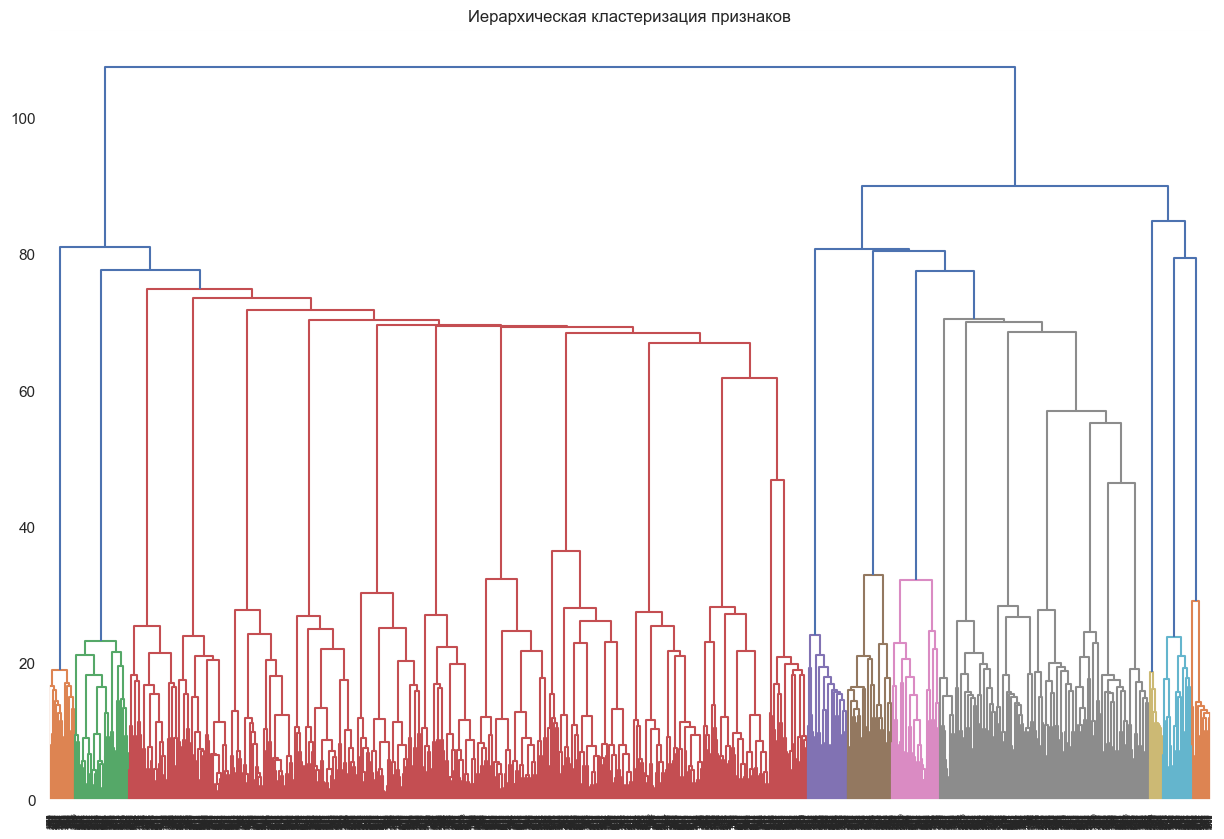

In [80]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация признаков')
plt.show()

In [81]:
# Оставим 5 кластеров, как более-менее приемлемое число
km = KMeans(n_clusters=5, random_state=0)

In [82]:
labels = km.fit_predict(x_sc)

In [83]:
final_df_clust['cluster_km'] = labels
final_df['cluster_km'] = labels

In [84]:
cluster_table = final_df_clust.drop(['user_id', 'answer_id'], axis = 1).groupby(by = 'cluster_km').mean()
cluster_table = pd.merge(cluster_table, 
                         final_df_clust.pivot_table(index = 'cluster_km',
                                                    values = 'user_id',
                                                    aggfunc = 'count'), on = 'cluster_km')

cluster_table = pd.merge(cluster_table, 
                         final_df.pivot_table(index = 'cluster_km',
                                              columns = 'cur_segm_last',
                                                    values = 'user_id',
                                                    aggfunc = 'count'), on = 'cluster_km')

cols = cluster_table.columns.tolist()
cols = cols[-4:] + cols[:-4]
cluster_table = cluster_table[cols]

display(cluster_table.style.background_gradient('coolwarm'))

,user_id,b2b,b2c,b2g,last_perf_evaluation,is_perf_grow,mean_value_statement_content,is_segment_changed,is_cohort_changed,над чем поработать_куда расти,над чем поработать_оценка шансов на трудоустройство,над чем поработать_персональная консультация,над чем поработать_портфолио,над чем поработать_практикум не сможет помочь,над чем поработать_про повышение,над чем поработать_профориентация,над чем поработать_резюме,над чем поработать_собеседования,над чем поработать_сопроводительное,над чем поработать_стратегия поиска работы,над чем поработать_тестовые,над чем поработать_устройство рынка труда,нашёл работу?_В активном поиске,нашёл работу?_Да,нашёл работу?_Нет,опыт_Более 3 лет опыта,опыт_Менее 1 года опыта др.,опыт_Менее года в аналитике,опыт_Нет опыта,опыт_От 1 года опыта др.,опыт_От 1 до 3 лет аналитиком?,"планы на трек_да, план","планы на трек_да, уже",планы на трек_нет,цель_Сменить работу.,цель_бизнес,цель_карьера,цель_нет цели,цель_новые знания - общее развитие,цель_новые знания - рост ЗП,цель_структурировать знания
cluster_km,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1588,11,734,843,0.706761,0.368388,0.787106,0.028967,0.081864,0.057305,0.098866,0.084383,0.112091,0.002519,0.045340,0.067380,0.098866,0.100126,0.079345,0.082494,0.096977,0.070529,0.000000,0.000000,0.989924,0.044081,0.030227,0.027708,0.701511,0.143577,0.052897,1.000000,0.000000,0.000000,0.641688,0.013854,0.054786,0.017003,0.119018,0.108312,0.045340
1,895,3,468,424,0.718011,0.383799,0.950861,0.017877,0.044693,0.062570,0.082682,0.078212,0.106145,0.005587,0.029050,0.058101,0.096089,0.102793,0.098324,0.091620,0.116201,0.072626,0.000000,0.000000,0.998883,0.035754,0.034637,0.034637,0.729609,0.127374,0.037989,0.000000,1.000000,0.000000,0.813408,0.006704,0.045810,0.010056,0.040223,0.056983,0.026816
2,260,7,177,76,0.718762,0.319231,0.829074,0.015385,0.069231,0.084615,0.026923,0.034615,0.034615,0.392308,0.080769,0.038462,0.065385,0.050000,0.050000,0.023077,0.073077,0.015385,0.030769,0.061538,0.873077,0.150000,0.046154,0.042308,0.407692,0.203846,0.150000,0.026923,0.003846,0.969231,0.146154,0.023077,0.088462,0.080769,0.373077,0.153846,0.134615
3,185,2,114,69,0.757474,0.383784,0.951943,0.027027,0.091892,0.048649,0.043243,0.064865,0.081081,0.027027,0.129730,0.054054,0.129730,0.097297,0.081081,0.086486,0.102703,0.054054,0.000000,1.000000,0.000000,0.097297,0.081081,0.264865,0.200000,0.194595,0.162162,0.578378,0.243243,0.178378,0.216216,0.016216,0.237838,0.010811,0.172973,0.243243,0.102703
4,596,2,324,270,0.698038,0.379195,1.024866,0.025168,0.036913,0.045302,0.075503,0.077181,0.082215,0.000000,0.036913,0.046980,0.120805,0.107383,0.112416,0.102349,0.088926,0.050336,0.937919,0.000000,0.000000,0.035235,0.057047,0.030201,0.714765,0.102349,0.060403,0.375839,0.573826,0.006711,0.791946,0.005034,0.033557,0.003356,0.028523,0.060403,0.033557


**КЛАСТЕРЫ** <br>

---
---


**Кластер 0** - **" Очень самостоятельные студенты "** - Самый маленький из всех кластеров. Большинство студентов из сегмента b2c. Средняя успеваемость в учебе. Самый низкий показатель роста успеваемости. Довольно низкий показатель уверенности в своих знаниях. Реже всех меняли свой сегмент, переходя из b2g в b2c. На втором месте по частоте академов и, соответственно, переходов в другую когорту. Чаще остальных хотят помощи с определением траекторий роста, помощью с повышением, также чаще всех отвечают, что практикум не может им ничем помочь. На втором месте по доле тех, кто уже нашел работу, много тех, у кого уже есть обширный опыт, в т.ч. аналитиком. Почти никто в этом кластере не планирует записываться на карьерный трек. Основные цели в порядке убывания – общее развитие, структурирование знаний, отсутствие цели, бизнес.
<br>
<br>
**Кластер 1** - **"Новички, которые хотят войти в IT"** - Самый большой из всех кластеров. Большинство студентов из сегмента b2g. Почти самая низкая успеваемость в учебе. Самый низкий показатель уверенности в своих знаниях. Чаще всех меняли свой сегмент, переходя из b2g в b2c, чаше всех брали академы и, соответственно, переходили в другую когорту. Чаще остальных хотят помощи с определением профессиональной сферы. Чаще всех хотят помощи с оформлением портфолио и оценкой шансов на трудоустройство, объяснением устройства рынка труда. Чаще всех отвечают, что не нашли работу, очень часто - что у них нет опыта работы. Все они еще только планируют записаться на карьерный трек после диплома. Основная цель - сменить работу. Примерно 9% также хотят учиться ради общего развития.
<br>
<br>
**Кластер 2** - **"Очень замотивированные новички, которые хотят войти в IT"** - Второй по размерам кластер. В основном b2c, но много b2g. Относительно высокая успеваемость, самый высокий показатель роста успеваемости, высокий показатель уверенности в своих знаниях. Мало тех, кто менял сегмент и когорту. Довольно заинтересованы в практически всем набором помощи начинающим - с тестовыми заданиями, стратегией поиска работы, подготовкой к собеседованию. *Еще не нашли работу, не имеют опыта, но уже записались на карьерный трек до окончания обучения - это их ключевое отличие от обычных новичков*. Основная цель - сменить работу.  
<br>
**Кластер 3 - "Ветераны хедхантера"** - Довольно малочисленный кластер. В основном b2c, но много b2g. Низкие показатели успеваемости при высокой доле тех, у кого она в процессе обучения выросла. Самая высокая степень уверенности в своих знаниях. Реже прочих меняли когорту или сегмент. Больше всех остальных кластеров хотят помощи с резюме, сопроводительным письмом, стратегией поиска работы, поведением на собеседовании. *Ключевой отличительный признак - находятся в активном поиске работы*. Не имеют в основном опыта работы. Уже записаны на карьерный трек. Основная цель - сменить работу.  
<br>
<br>
**Кластер 4 - "Профессионалы в сфере, которые пришли за профессиональным ростом"** - Третий по размерам кластер. В основном b2c, но много b2g. Самая высокая успеваемость. Много менявших сегмент или когорту. Заинтересованы в помощи в получении повышения или определения стратегии профессионального роста. *Более прочих заинтересованы в карьерных консультациях и корректировке резюме*. Чаще всех отвечают, что нашли работу, чаще всех имеют рабочий опыт, чаще всех имеют опыт в аналитике. В целом скорее планируют записаться на карьерный трек после диплома. *Самые популярные цели - повышение ЗП, продвижение по карьерной лестнице, структурирование уже полученных навыков и знаний*.
 


### Сформулируем гипотезы исходя из кластеров (2 крупных кластера - "новички" и "профессионалы")

**Проверка гипотезы 1: средняя доля выбора студентами резюме, портфолио, сопроводительное для категории с опытом менее 1 года равна доле выбора этих категорий более опытными студентами**

Для проверки гипотезы будем использовать специальный метод для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам: t-тест Уэлча. Для проверки гипотез был выбран t-тест Уэлча как модификация Т-критерия Стьюдента, поскольку он используется для проверки равенства средних значений у независимых выборок.

H_0: средняя доля выбора студентами резюме, портфолио, сопроводительное для категории с опытом менее 1 года равна доле выбора этих категорий более опытными студентами; \
H_a: средняя доля выбора студентами резюме, портфолио, сопроводительное для категории с опытом менее 1 года не равна доле выбора этих категорий более опытными студентами;

Уровень существенности установим: alpha = 0.05/2 (так как для данной категории проверяем 2 гипотезы)

In [85]:
#данные для гипотезы 1
hypoth_1 = final_df[['user_id',
                     'над чем поработать_портфолио', 
                     'над чем поработать_резюме', 
                     'над чем поработать_сопроводительное',
                     'над чем поработать_собеседования',
                     'над чем поработать_стратегия поиска работы',
                     'над чем поработать_тестовые', 
                     'опыт_Более 3 лет опыта', 
                     'опыт_От 1 года опыта др.',  
                     'опыт_От 1 до 3 лет аналитиком?']]

hypoth_1['total_artef'] = (hypoth_1['над чем поработать_портфолио'] + 
                           hypoth_1[ 'над чем поработать_резюме']+ 
                           hypoth_1['над чем поработать_сопроводительное'] + 
                           hypoth_1['над чем поработать_собеседования'] + 
                           hypoth_1['над чем поработать_стратегия поиска работы']+
                           hypoth_1['над чем поработать_тестовые'])/6
hypoth_1['exp_more_1'] = hypoth_1['опыт_От 1 года опыта др.'] +hypoth_1[ 'опыт_От 1 до 3 лет аналитиком?'] + hypoth_1['опыт_Более 3 лет опыта']

hypoth_1.head()

C:\Users\CaIII\AppData\Local\Temp\ipykernel_17100\1003093493.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hypoth_1['total_artef'] = (hypoth_1['над чем поработать_портфолио'] +
C:\Users\CaIII\AppData\Local\Temp\ipykernel_17100\1003093493.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hypoth_1['exp_more_1'] = hypoth_1['опыт_От 1 года опыта др.'] +hypoth_1[ 'опыт_От 1 до 3 лет аналитиком?'] + hypoth_1['опыт_Более 3 лет опыта']


,user_id,над чем поработать_портфолио,над чем поработать_резюме,над чем поработать_сопроводительное,над чем поработать_собеседования,над чем поработать_стратегия поиска работы,над чем поработать_тестовые,опыт_Более 3 лет опыта,опыт_От 1 года опыта др.,опыт_От 1 до 3 лет аналитиком?,total_artef,exp_more_1
0,3157,0,0,0,0,0,1,0,0,0,0.167,0
1,5415,0,0,0,0,1,0,0,1,0,0.167,1
2,8199,1,0,0,0,0,0,0,0,0,0.167,0
3,8215,0,0,0,0,0,0,0,0,0,0.000,0
4,10202,0,0,0,0,1,0,1,0,0,0.167,1


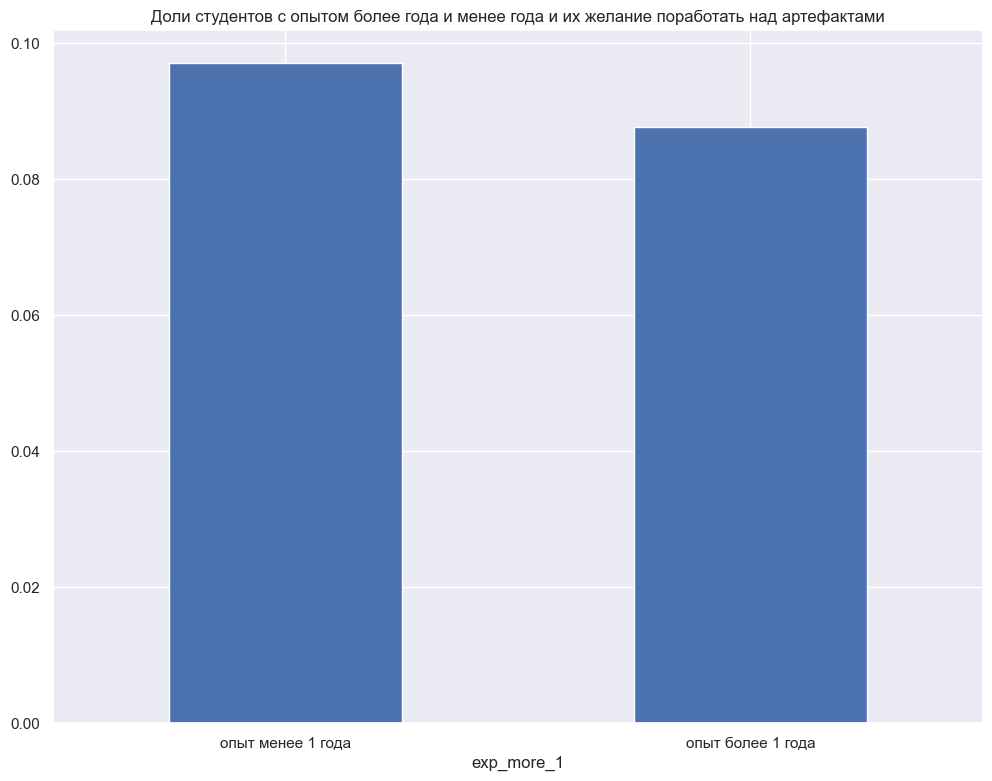

In [86]:
#визуализация по опыту и артефактам

x = [0,1]
hypoth_1.groupby('exp_more_1')['total_artef'].mean().plot(kind = 'bar')

plt.xticks(x, ['опыт менее 1 года', 'опыт более 1 года'], rotation = 0)
plt.title('Доли студентов с опытом более года и менее года и их желание поработать над артефактами')

plt.savefig('plot_2.svg', format = 'svg')

In [87]:
# alpha
alpha =0.05/2

# results = вызов метода для проверки гипотезы
results = st.ttest_ind(
    hypoth_1[hypoth_1['exp_more_1'] == 0]['total_artef'], 
    hypoth_1[hypoth_1['exp_more_1'] != 0]['total_artef'], equal_var = False)

print(results.pvalue) # вывод значения p-value на экран 

# условный оператор с выводом строки с ответом
if results.pvalue < alpha: 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

0.0036596551521982526
Отвергаем нулевую гипотезу


**Студенты с опытом работы менее года в сфере аналитики и другой отрасли выбирают как объекты над чем поработать "артефакты", такие как резюме, сопроводительное, порфолио, собеседования, стратегия поиска работы, тестовые чаще, чем студенты с опытом работы более года. Отвергаем нулевую гипотезу.**

**Проверка гипотезы 2: средняя доля выбора студентами "куда расти" и "повышение" для категории с опытом более 1 года равна доле выбора этих категорий менее опытными студентами**

Для проверки гипотезы будем использовать специальный метод для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам: t-тест Уэлча. Для проверки гипотез был выбран t-тест Уэлча как модификация Т-критерия Стьюдента, поскольку он используется для проверки равенства средних значений у независимых выборок.

H_0: средняя доля выбора студентами "куда расти" и "повышение" для категории с опытом более 1 года равна доле выбора этих категорий менее опытными студентами; \
H_a: средняя доля выбора студентами "куда расти" и "повышение" для категории с опытом более 1 года не равна доле выбора этих категорий менее опытными студентами;

Уровень существенности установим: alpha = 0.05/2

In [88]:
#данные для гипотезы 2

hypoth_2 = final_df[['user_id','над чем поработать_куда расти', 'над чем поработать_про повышение', 'опыт_От 1 года опыта др.',  'опыт_От 1 до 3 лет аналитиком?']]

hypoth_2['total_goals'] = (hypoth_2['над чем поработать_куда расти'] +hypoth_2[ 'над чем поработать_про повышение'])/2
hypoth_2['exp_more_1'] = hypoth_2['опыт_От 1 года опыта др.'] +hypoth_2[ 'опыт_От 1 до 3 лет аналитиком?']

hypoth_2.head()

C:\Users\CaIII\AppData\Local\Temp\ipykernel_17100\1221370880.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hypoth_2['total_goals'] = (hypoth_2['над чем поработать_куда расти'] +hypoth_2[ 'над чем поработать_про повышение'])/2
C:\Users\CaIII\AppData\Local\Temp\ipykernel_17100\1221370880.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hypoth_2['exp_more_1'] = hypoth_2['опыт_От 1 года опыта др.'] +hypoth_2[ 'опыт_От 1 до 3 лет аналитиком?']


,user_id,над чем поработать_куда расти,над чем поработать_про повышение,опыт_От 1 года опыта др.,опыт_От 1 до 3 лет аналитиком?,total_goals,exp_more_1
0,3157,0,0,0,0,0.0,0
1,5415,0,0,1,0,0.0,1
2,8199,0,0,0,0,0.0,0
3,8215,0,0,0,0,0.0,0
4,10202,0,0,0,0,0.0,0


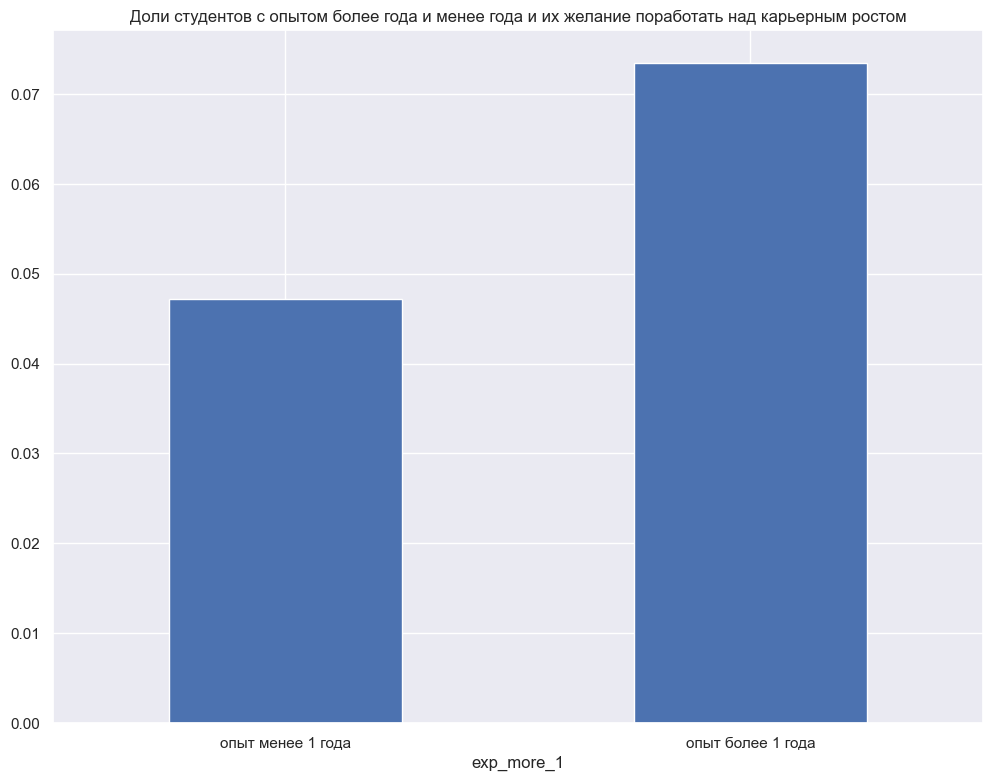

In [89]:
#визуализация по опыту и куда рости и повышение

x = [0,1]

hypoth_2.groupby('exp_more_1')['total_goals'].mean().plot(kind = 'bar')

plt.xticks(x, ['опыт менее 1 года', 'опыт более 1 года'], rotation = 0)
plt.title('Доли студентов с опытом более года и менее года и их желание поработать над карьерным ростом')

plt.savefig('plot_3.svg', format = 'svg')

In [90]:
# alpha
alpha =0.05/2

# results = вызов метода для проверки гипотезы
results = st.ttest_ind(
    hypoth_2[hypoth_2['exp_more_1'] == 1]['total_goals'], 
    hypoth_2[hypoth_2['exp_more_1'] != 1]['total_goals'], equal_var = False)

print(results.pvalue) # вывод значения p-value на экран 

# условный оператор с выводом строки с ответом
if results.pvalue < alpha: 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

0.00026606257131201285
Отвергаем нулевую гипотезу


**Студенты с опытом работы более года в сфере аналитики и другой отрасли выбирают чаще куда расти и как говорить про повышение, чем студенты с опытом работы менее года. Нулевую гипотезу отвергаем.**

## Выводы

На основе данных были сформулированы 5 основных кластеров.

**КЛАСТЕРЫ** <br>

---
---


**Кластер 0** - **" Очень самостоятельные студенты "** 
<br>
<br>
**Кластер 1** - **"Новички, которые хотят войти в IT"**  
<br>
**Кластер 2** - **"Очень замотивированные новички, которые хотят войти в IT"** 
<br>
<br>
**Кластер 3 - "Ветераны хедхантера"** 
<br>
<br>
**Кластер 4 - "Профессионалы в сфере, которые пришли за профессиональным ростом"** 

---
---

Исходя из этих кластеров сформулированы 2 гипотезы:
* Cредняя доля выбора студентами резюме, портфолио, сопроводительное для категории с опытом менее 1 года равна доле выбора этих категорий более опытными студентами

* средняя доля выбора студентами "куда расти" и "повышение" для категории с опытом более 1 года равна доле выбора этих категорий менее опытными студентами

Студенты с опытом работы менее года в сфере аналитики и другой отрасли выбирают как объекты над чем поработать "артефакты", такие как резюме, сопроводительное, порфолио и др. чаще, чем студенты с опытом работы более года. Нулевая гипотеза была отвергнута. **Это значит, что пользователям без опыта важнее работать с артефактами (резюме, сопроводительное, портфолио), чем пользователям с опытом более года **

Студенты с опытом работы более года в сфере аналитики и другой отрасли выбирают чаще куда расти и как говорить про повышение, чем студенты с опытом работы менее года. Нулевую гипотезу отвергаем. **Это значит, что более опытным студентам можно предлагать дополнительную информацию в рамках обучение о росте и перспективах на рынке**



## Сегментация студентов


---



**Описание раздела:**

Далее будет представлена сегментация студентов по категориям "сегменты b2b, b2g, b2c", "профессии (дата-аналитики, сайентисты и прочие)", а также будут рассмотрены пользователи, которые не видят помощи от Практикума по решении их целей


In [91]:
# В отдельные переменные сохраняем название колонок по смыслу

directions_to_raise_skills = ['над чем поработать_куда расти',
       'над чем поработать_оценка шансов на трудоустройство',
       'над чем поработать_персональная консультация',
       'над чем поработать_портфолио',
       'над чем поработать_практикум не сможет помочь',
       'над чем поработать_про повышение', 
       'над чем поработать_профориентация',
       'над чем поработать_резюме',
        'над чем поработать_собеседования',
       'над чем поработать_сопроводительное',
       'над чем поработать_стратегия поиска работы',
       'над чем поработать_тестовые',
       'над чем поработать_устройство рынка труда']
expierence = ['опыт_Нет опыта', 'опыт_Менее года в аналитике',
              'опыт_От 1 до 3 лет аналитиком?','опыт_Более 3 лет опыта',
        'опыт_От 1 года опыта др.','опыт_Менее 1 года опыта др.']
plans_for_track = ['планы на трек_да, план',
       'планы на трек_да, уже', 'планы на трек_нет']
goals = ['цель_Сменить работу.',
       'цель_бизнес', 'цель_карьера', 'цель_нет цели',
       'цель_новые знания - общее развитие', 'цель_новые знания - рост ЗП',
       'цель_структурировать знания']
find_job = ['нашёл работу?_В активном поиске', 'нашёл работу?_Да',
       'нашёл работу?_Нет']
user_metrics = ['profession_name', 'mean_perf_evaluation',
       'is_perf_grow', 'mean_user_recommend_value',
       'mean_value_statement_content', 'day_of_week', 'hour', 'cur_segm_last',
       'is_segment_changed', 'is_cohort_changed']

# В отдельные переменные сохраняем название колонок по типу переменных внутри
binary_metrics = directions_to_raise_skills+expierence+plans_for_track+goals+find_job+['is_perf_grow', 'is_segment_changed', 'is_cohort_changed']
category_metrics = ['profession_name',  'day_of_week', 'hour', 'cur_segm_last']
values_metrics = ['mean_perf_evaluation', 'mean_user_recommend_value', 'mean_value_statement_content']

### Кто те, кто хочет сменить работу и не имеет опыта в аналитике

In [92]:
# В переменной сохраняем только тех студентов, которые отметили, что их цель сменить работу
students_changers = final_df[final_df['цель_Сменить работу.'] == 1]

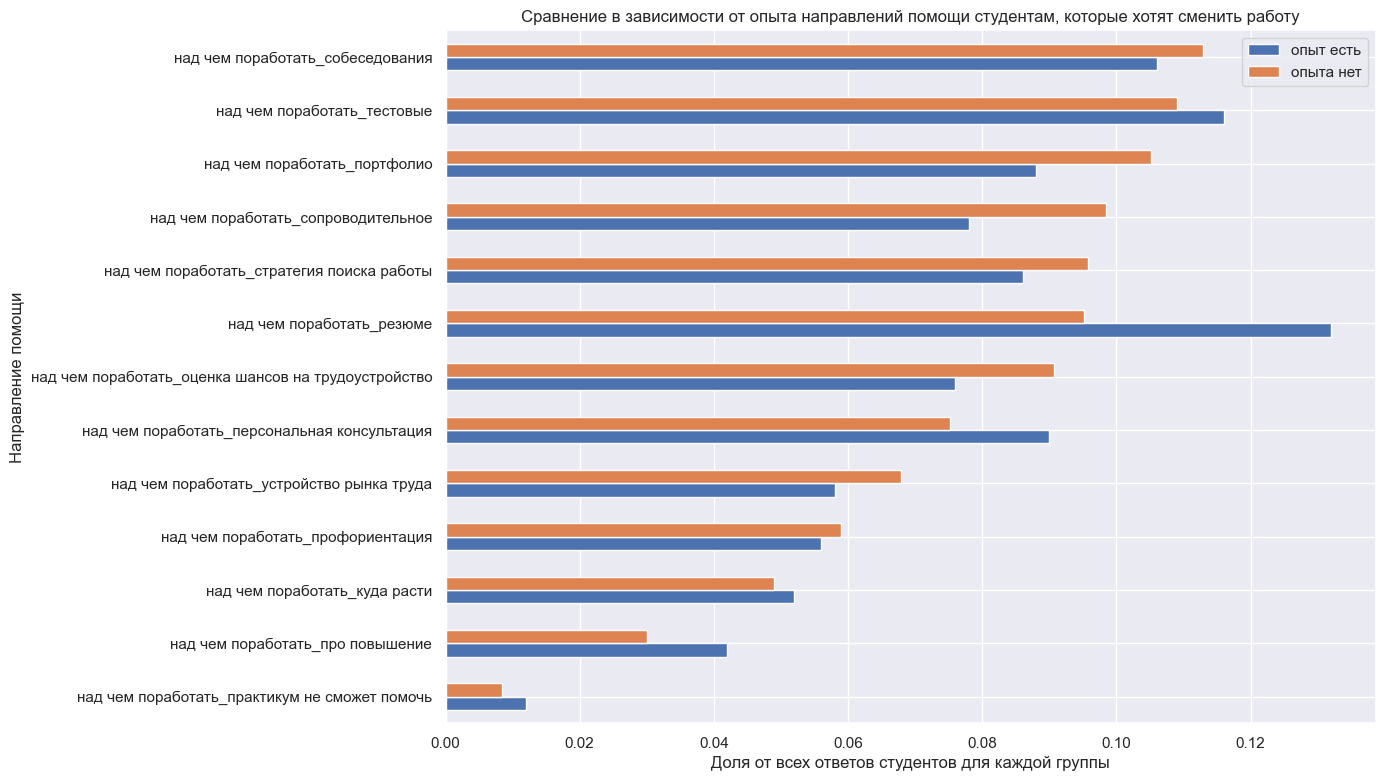

In [93]:
# Строим сравнительный график направлений помощи для студентов, которые имеют и не имеют опыта работы в аналитике
students_changers.groupby('опыт_Нет опыта')[[c for c in list(final_df.columns) if c.startswith('над чем поработать') ]]\
.mean().T.sort_values(by=1).reset_index().set_axis(['Направление помощи','опыт есть','опыта нет'], axis=1,inplace=False).plot.barh(x='Направление помощи')

plt.xlabel('Доля от всех ответов студентов для каждой группы')
plt.ylabel('Направление помощи')
plt.title('Сравнение в зависимости от опыта направлений помощи студентам, которые хотят сменить работу')
plt.show()

Для тех у кого нет опыта, резюме не так важно, как тем у кого он есть.

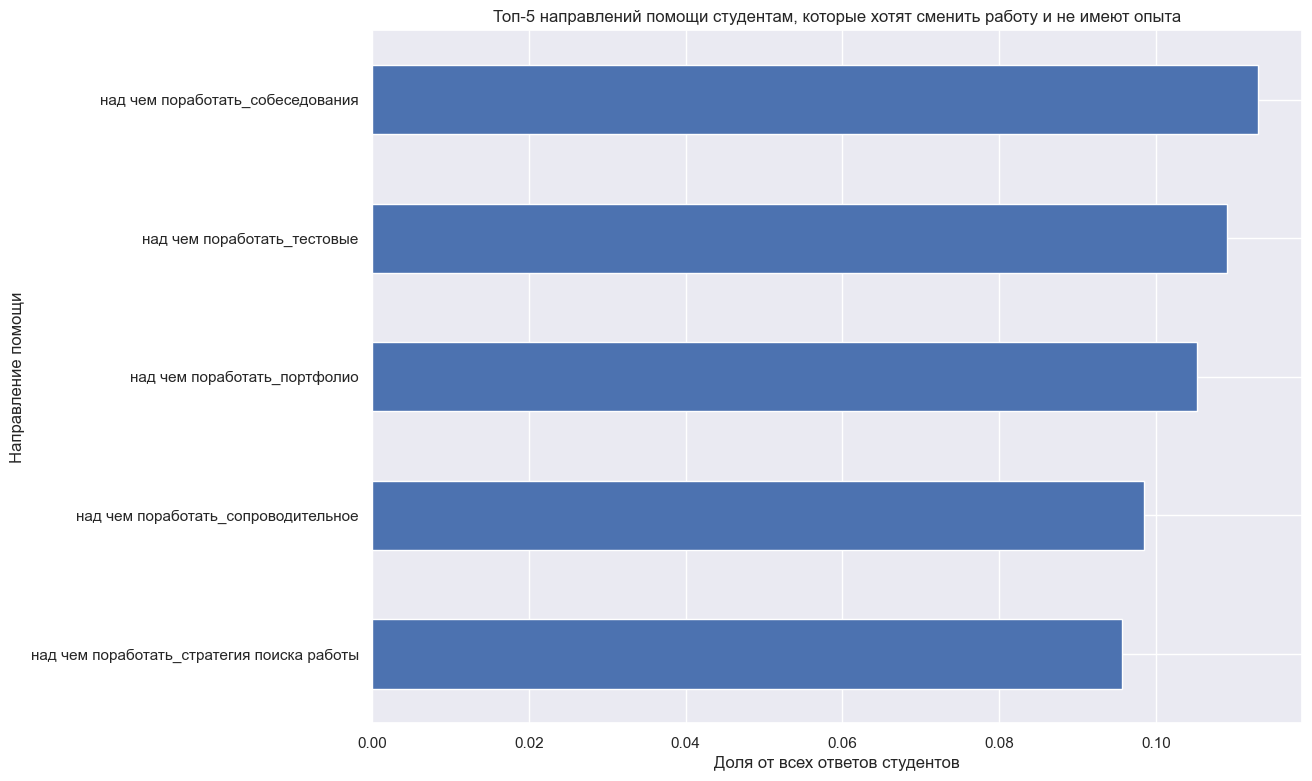

In [94]:
# Топ 5 направлений помощи выделенных студентами без опыта и обучающихся с целью смены работы
students_changers[students_changers['опыт_Нет опыта']==1][[c for c in list(final_df.columns) if c.startswith('над чем поработать') ]]\
.mean().T.sort_values().reset_index().tail().plot.barh(x='index',legend=False)

plt.xlabel('Доля от всех ответов студентов')
plt.ylabel('Направление помощи')
plt.title('Топ-5 направлений помощи студентам, которые хотят сменить работу и не имеют опыта')

plt.show()

Мы видим, что для тех, кто нацелен на смену работы, важны артефакты поиска работы - собеседования, тестовые, портфолио, сопроводительное, а также стратегия поиска работы.

### Сегментация студентов по сегменту обучения

Разделим студентов на группы по сегментам обучения : b2b, b2с и b2g. Посмотрим основные показатели и характеристики для каждой группы.  
#### Сегменты студентов и цели обучения.

In [95]:
goals_by_segment = final_df.pivot_table(index='cur_segm_last', 
                     values=[c for c in list(final_df.columns) if c.startswith('цель_') ], 
                     aggfunc='mean').T.sort_values(by='b2c').reset_index().set_axis(['Цель','Сегмент B2B',
                                                                                                    'Сегмент B2C',
                                                                                                    'Сегмент B2G'],
                                                                                                    axis=1,
                                                                                                    inplace=False)
display (goals_by_segment)

,Цель,Сегмент B2B,Сегмент B2C,Сегмент B2G
0,цель_бизнес,0.00,0.010,0.012
1,цель_нет цели,0.00,0.018,0.017
2,цель_структурировать знания,0.08,0.057,0.039
3,цель_карьера,0.24,0.069,0.049
4,цель_новые знания - рост ЗП,0.20,0.107,0.086
5,цель_новые знания - общее развитие,0.12,0.119,0.090
6,цель_Сменить работу.,0.32,0.610,0.702


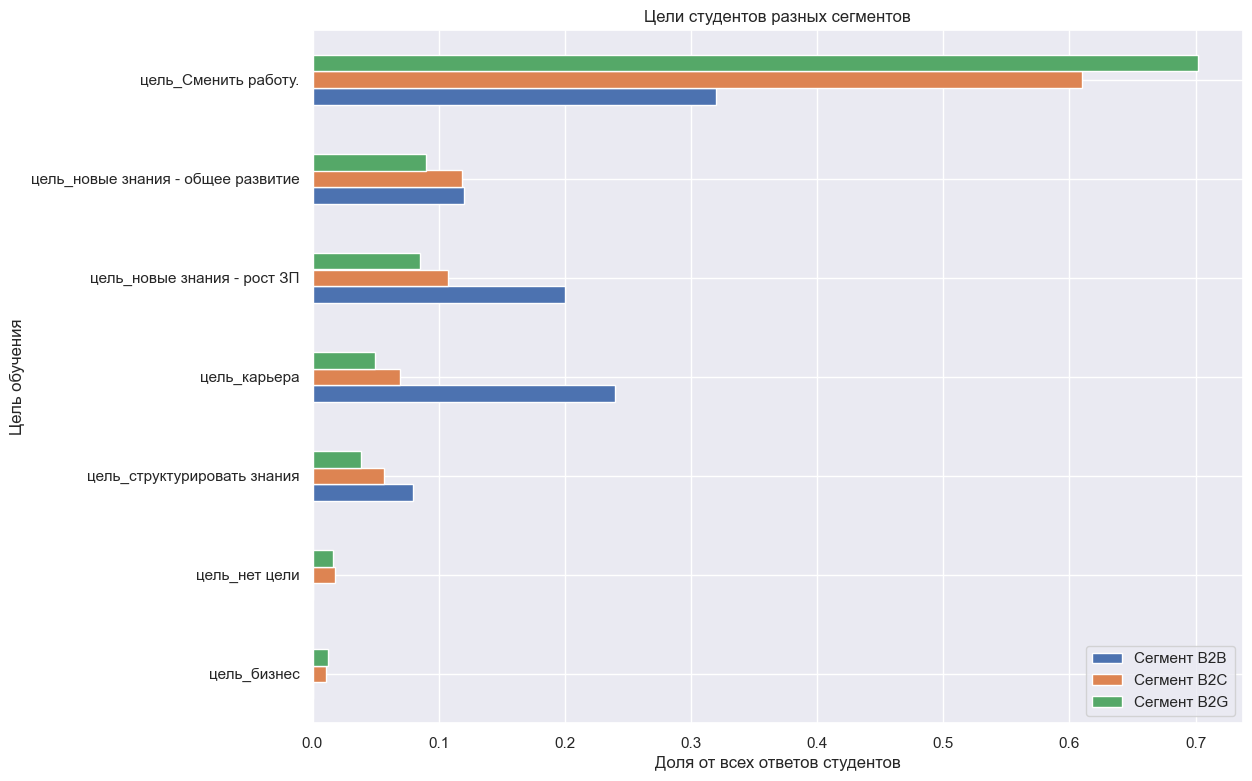

In [96]:
# График целей и доли выбора её студентами разных сегментов - насколько часто выбрали ту или иную цель
goals_by_segment.plot.barh(x='Цель')
plt.xlabel('Доля от всех ответов студентов')
plt.ylabel('Цель обучения')
plt.title('Цели студентов разных сегментов')

plt.show()

Для студентов всех сегментов характерна основная цель - смена работы.  
Отличен от двух других сегмент В2В. Вторая по важности цель этих студентов - продвижение по карьерной лестнице. Это нормально, т.к. обучение студентов сегмента В2В происходит за счёт работодателя. Отметим малочисленность сегмента В2В, которую можно посмотреть выше на графике долей сегментам.

#### Направления помощи и сегменты

In [97]:
directions_by_segment = final_df.pivot_table(index='cur_segm_last', 
                     values=[c for c in list(final_df.columns) if c.startswith('над чем поработать') ], 
                     aggfunc='mean').T.sort_values(by='b2c').reset_index().set_axis(['Направление','Сегмент B2B',
                                                                                                    'Сегмент B2C',
                                                                                                    'Сегмент B2G'],
                                                                                                    axis=1,
                                                                                                    inplace=False)
display (directions_by_segment)

,Направление,Сегмент B2B,Сегмент B2C,Сегмент B2G
0,над чем поработать_практикум не сможет помочь,0.08,0.043,0.021
1,над чем поработать_про повышение,0.12,0.048,0.045
2,над чем поработать_профориентация,0.04,0.052,0.067
3,над чем поработать_устройство рынка труда,0.04,0.054,0.073
4,над чем поработать_куда расти,0.08,0.056,0.060
5,над чем поработать_персональная консультация,0.04,0.080,0.074
6,над чем поработать_оценка шансов на трудоустройство,0.08,0.081,0.084
7,над чем поработать_стратегия поиска работы,0.04,0.082,0.087
8,над чем поработать_собеседования,0.08,0.095,0.102
9,над чем поработать_сопроводительное,0.08,0.095,0.080


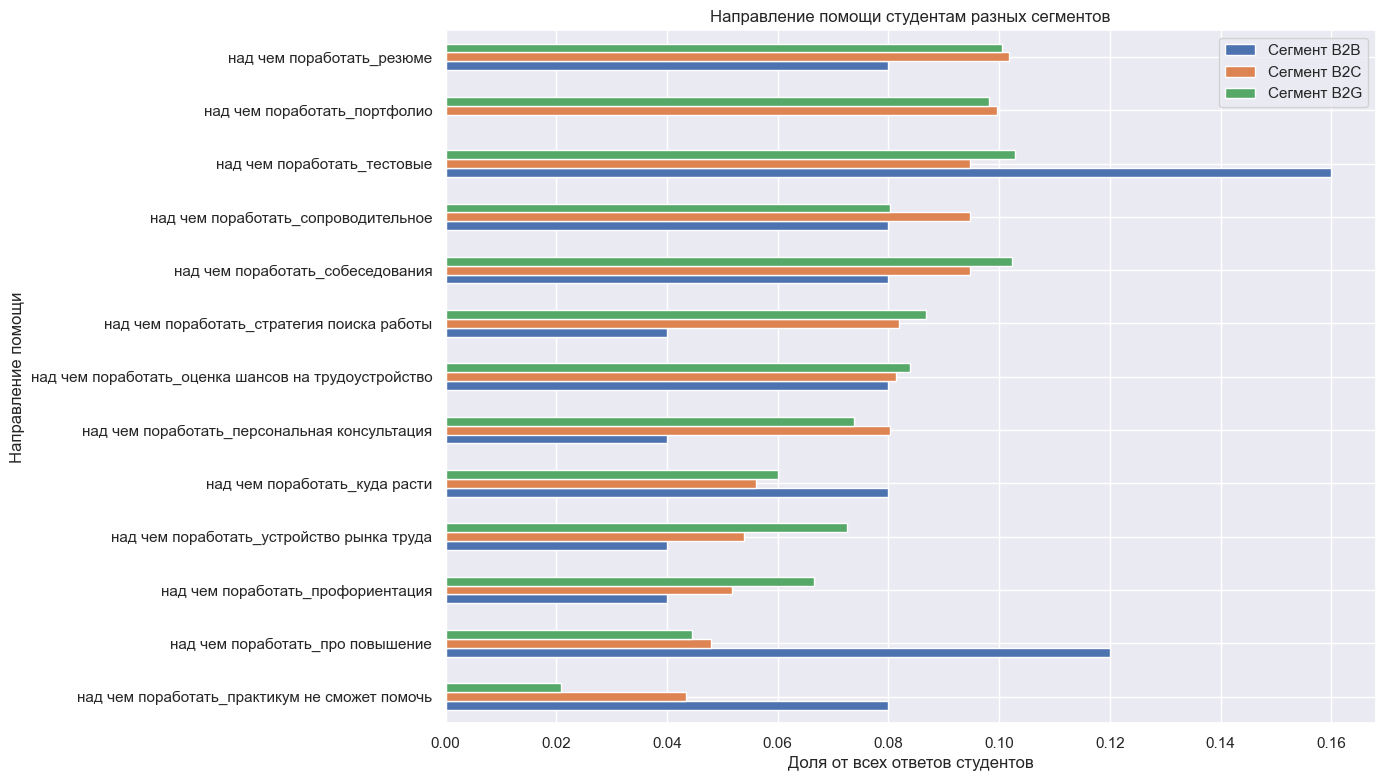

In [98]:
# График направлений и доли выбора её студентами разных сегментов - насколько часто выбрали то или иное направление помощи
directions_by_segment.plot.barh(x='Направление')
plt.xlabel('Доля от всех ответов студентов')
plt.ylabel('Направление помощи')
plt.title('Направление помощи студентам разных сегментов')

plt.show()

Студенты из В2В выбирают в основном работу над тестовыми и как говорить про повышение. Среди них большее всего пессимистов - тех, кто считает, что практикум не сможет помочь. Мы предполагаем, что это связано с тем, что студенты B2B в меньшей степени, чем остальные нацелены на смену работу и поэтому карьерный трек им нужен больше для продвижения по карьере, а в случае со сменой работы - прокачка тестовых задачек.  
  
    
Рассмотрим цель - Сменить работу для каждого сегмента.

In [99]:
hypothesis_segment_goal = final_df.pivot_table(index='cur_segm_last', 
                                               values='цель_Сменить работу.',
                                               aggfunc=['mean',
                                                        'sum',
                                                        'count']).reset_index().set_axis(['Сегмент',
                                                                                          'share_change_job',
                                                                                                    'count_change_job',
                                                                                                    'total_count'],
                                                                                                    axis=1,
                                                                                                    inplace=False)
hypothesis_segment_goal

,Сегмент,share_change_job,count_change_job,total_count
0,b2b,0.320,8.0,25
1,b2c,0.610,1108.0,1817
2,b2g,0.702,1181.0,1682


Cравним доли студентов из групп b2c и b2g по по ответам на вопрос о цели обучения "Смена работы". Из 1791 студентов b2c у 1104 отметили смену работы как цель; а из 1682 сегмента b2g, отметили — 1181.  
Формулируем гипотезы:  
H0: Доля сегмента b2c, ответивших на вопрос о цели обучения как смена работы, равна доле студентов сегмента b2g, ответивших также на этот вопрос  
H1: Доля сегмента b2c, ответивших на вопрос о цели обучения как смена работы, не равна доле студентов сегмента b2g, ответивших также на этот вопрос  

In [100]:
# Функция для проверки гипотез о равенстве долей
def z_test(successes,trials,alpha=.05):

    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        ) 

In [101]:
z_test(successes = np.array(hypothesis_segment_goal[1:]['count_change_job']),
       trials = np.array(hypothesis_segment_goal[1:]['total_count']))

p-значение:  9.584062876655253e-09
Отвергаем нулевую гипотезу: между долями есть значимая разница


Т.к. мы отвергнули нулевую гипотезу, считаем разницу между долями в сегментах статистически значимой. Следовательно, для сегмента b2g больше характерна нацеленность на смену работы, чем для других.  
Посмотрим насколько различается ответы студентов разных сегментов об отсутствие опыта. 

In [102]:
hypothesis_segment_exp = final_df.pivot_table(index='cur_segm_last', values='опыт_Нет опыта', aggfunc=['mean','sum','count']).reset_index().set_axis(['segment','share_no_exp',
                                                                                                    'count_no_exp',
                                                                                                    'total_count'],
                                                                                                    axis=1,
                                                                                                    inplace=False)
hypothesis_segment_exp

,segment,share_no_exp,count_no_exp,total_count
0,b2b,0.400,10.0,25
1,b2c,0.599,1088.0,1817
2,b2g,0.736,1238.0,1682


Доля студентов, указавших на отсутствие опыта в сегменте b2g значительно выше b2с. Проверим статистическую значимость различий.  

**Формулируем гипотезы:**  

**H0:** Доля сегмента b2c, ответивших на вопрос об опыте как его отсутствие, равна доле студентов сегмента b2g, ответивших также на этот вопрос  

**H1:** Доля сегмента b2c, ответивших на вопрос об опыте как его отсутствие, не равна доле студентов сегмента b2g, ответивших также на этот вопрос  

In [103]:
z_test(successes = np.array(hypothesis_segment_exp[1:]['count_no_exp']),
       trials = np.array(hypothesis_segment_exp[1:]['total_count']))

p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница


Так как в обоих случаях проверки гипотез мы получили достаточно маленькие значения p_value<0.01, значение выводов не изменит корректировка уровня значимости при множественной проверке гипотез.  
Посмотрим на среднюю успеваемость студентов в сегментах b2c и b2g

In [104]:
print('Средняя успеваемость студентов b2c',round(final_df[final_df['cur_segm_last']=='b2c']['last_perf_evaluation'].mean(),2))
print('Средняя успеваемость студентов b2g',round(final_df[final_df['cur_segm_last']=='b2g']['last_perf_evaluation'].mean(),2))

Средняя успеваемость студентов b2c 0.73
Средняя успеваемость студентов b2g 0.69


Проверим гипотезы о статистической значимости разниц в средних  

**Формулируем гипотезы:**  

**H0:** Средняя успеваемость студентов сегмента b2c равна средней успеваемости студентов сегмента b2g  

**H1:** Средняя успеваемость студентов сегмента b2c не равна средней успеваемости студентов сегмента b2g  
  
Для проверки будем использовать тест Стьюдента для независимых выборок и считаем, что дисперсии генеральных совокупностей не равны, т.к. студенты этих сегментов высказывают разные цели обучения

In [105]:
alpha = .05 # критический уровень статистической значимости

results = st.ttest_ind(final_df[final_df['cur_segm_last']=='b2c']['last_perf_evaluation'], # средняя успеваемость студентов b2c
                       final_df[final_df['cur_segm_last']=='b2g']['last_perf_evaluation'], # средняя успеваемость студентов b2g
                       equal_var= False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 1.275671537712711e-16
Отвергаем нулевую гипотезу


Мы получили, что различия в среднем значении успеваемости студентов двух сегментов статистически значимы. Следовательно, студенты сегмента b2g в среднем учатся хуже.

Посмотрим, может ли это быть связано с временем занятий или днём недели  

**Сформулируем гипотезы**

**H0:** Доля студентов сегмента b2g, у которых есть рост успеваемости и которые учатся в основном с 4 до 8 часов (Early Morning) равна доле студентов сегмента b2g, у которых есть рост успеваемости  и которые учатся в основном с 9 до 12 часов (Morning)  

**H1:** Доля студентов сегмента b2g, у которых есть рост успеваемости и которые учатся в основном с 4 до 8 часов (Early Morning) не равна доле студентов сегмента b2g, у которых есть рост успеваемости и которые учатся в основном с 9 до 12 часов (Morning)  

In [106]:
hypothesis_b2g_hour = final_df[final_df['cur_segm_last']=='b2g'].pivot_table(index='hour',
                                                                             values='is_perf_grow',
                                                                             aggfunc=['mean','sum','count']).reset_index().set_axis(['hour','share_perf_grow',
                                                                                                    'count_perf_grow',
                                                                                                    'total_count'],
                                                                                                    axis=1,
                                                                                                    inplace=False).sort_values(by='share_perf_grow', ascending=False)
hypothesis_b2g_hour

,hour,share_perf_grow,count_perf_grow,total_count
0,Early Morning,0.554,36.0,65
1,Evening,0.500,179.0,358
2,Late Night,0.473,62.0,131
5,Noon,0.445,183.0,411
4,Night,0.435,137.0,315
3,Morning,0.423,170.0,402


In [107]:
z_test(successes = np.array([hypothesis_b2g_hour['count_perf_grow'][0],hypothesis_b2g_hour['count_perf_grow'][3]]),
       trials = np.array([hypothesis_b2g_hour['total_count'][0],hypothesis_b2g_hour['total_count'][3]]))

p-значение:  0.04850188160605717
Отвергаем нулевую гипотезу: между долями есть значимая разница


Различия в росте успеваемости в зависимости от времени удалось обнаружить.  
Посмотрим на различия в днях недели.  

In [108]:
hypothesis_b2g_day = final_df[final_df['cur_segm_last']=='b2g'].pivot_table(index='day_of_week',
                                                                             values='is_perf_grow',
                                                                             aggfunc=['mean','sum','count']).reset_index().set_axis(['hour','share_perf_grow',
                                                                                                    'count_perf_grow',
                                                                                                    'total_count'],
                                                                                                    axis=1,
                                                                                                    inplace=False).sort_values(by='share_perf_grow', ascending=False).reset_index(drop=True)
hypothesis_b2g_day

,hour,share_perf_grow,count_perf_grow,total_count
0,Thursday,0.560,107.0,191
1,Wednesday,0.464,90.0,194
2,Friday,0.463,74.0,160
3,Monday,0.452,246.0,544
4,Saturday,0.448,64.0,143
5,Tuesday,0.436,134.0,307
6,Sunday,0.364,52.0,143


**Сформулируем гипотезы**

**H0:** Доля студентов сегмента b2g, у которых есть рост успеваемости и которые учатся в основном в четверг равна доле студентов сегмента b2g, у которых есть рост успеваемости и которые учатся в основном в воскресенье    

**H1:** Доля студентов сегмента b2g,, у которых есть рост успеваемости и которые учатся в основном в четверг не равна доле студентов сегмента b2g, у которых есть рост успеваемости  и которые учатся в основном в воскресенье  

In [109]:
z_test(successes = np.array([hypothesis_b2g_day['count_perf_grow'][0],hypothesis_b2g_day['count_perf_grow'][6]]),
       trials = np.array([hypothesis_b2g_day['total_count'][0],hypothesis_b2g_day['total_count'][6]]))

p-значение:  0.0003718474368248348
Отвергаем нулевую гипотезу: между долями есть значимая разница


Проверим, может ли сдвиги в количестве опытных студентов, обучающихся по четвергам, повлиять на рост успеваемости.

In [110]:
final_df[final_df['cur_segm_last']=='b2g'].pivot_table(index='day_of_week', 
                                                       values=['is_perf_grow','опыт_Нет опыта','нашёл работу?_Да'], 
                                                       aggfunc='mean')

,is_perf_grow,нашёл работу?_Да,опыт_Нет опыта
day_of_week,,,
Friday,0.463,0.069,0.781
Monday,0.452,0.035,0.744
Saturday,0.448,0.077,0.699
Sunday,0.364,0.056,0.685
Thursday,0.560,0.037,0.717
Tuesday,0.436,0.033,0.759
Wednesday,0.464,0.041,0.722


В четверг отвечает в среднем студенты с меньшим опытом, чем в воскресенье. Значит, опытность не повлияла на рост успешности в обучении у тех, кто отвечал в четверг. Могла повлиять текущая занятость: в среднем доля тех, кто указал в воскресенье, что уже нашёл работу, больше, чем тех, кто указал это в четверг. Но выборка этих людей крайне мала (7 и 8 человек нашли работу), чтобы делать значимый вывод. 

#### Выводы по сегментации студентов по сегментам обучения

У нас получились следующие результаты:  
* студенты сегмента b2g нацелены в основном больше на смену работы, чем студенты b2с  
* студенты сегмента b2g имеют меньше опыта, чем студенты b2с  
* средняя успеваемость студентов сегмента b2g ниже, чем студентов b2с  
* была обнаружена разница в росте успеваемости в зависимости от времени ответов студентов сегмента b2g: те, кто отвечают рано утром имеют больший рост успеваемости, чем те, кто отвечал утром, а также в среднем, те кто отвечал на вопросы анкеты в четверг, показывают больший рост успеваемости, чем те, кто отвечал в воскресенье.  
  
**Выводы.**

Студенты сегмента b2g больше всех хотят сменить работу, в то же время у них самый мальнький опыт и низкая успеваемость, на рост которой предположительно оказывает влияние день недели ответов, который связан с временем движения студента по спринту и сдачей проектов. Т.к. найти работу по новой специальности без хороших знаний по предмету достаточно сложно, то для помощи студентам из сегмента b2g предлагается внести изменения в учебный график. К сожалению, мы не знаем от чего зависит показатель успеваемости, поэтому приведём общие примеры того, что может улучшить усвоение нового материала:  

- смягчить дедлайны до четверга - больше времени на проработку для студента,  
- добавить больше консультаций - возможность выяснить то, что непонятно,  
- конкурс с призами на лучший конспект каждого спринта - самостоятельное структурирование знаний.


### Кто те, кто утверждает, что практикум им не может ничем помочь

In [111]:
pessimists = final_df[final_df['над чем поработать_практикум не сможет помочь']==1]
optimists = final_df[final_df['над чем поработать_практикум не сможет помочь']==0]

In [112]:
mean_metrics_optimists_vs_pessimists = optimists[binary_metrics].mean().reset_index().set_axis(['Вопрос','Среднее для оптимистов'],
                                                            axis=1, 
                                                            inplace=False).merge(pessimists[binary_metrics].mean().reset_index().set_axis(['Вопрос','Среднее для пессимистов'],
                                                            axis=1, 
                                                            inplace=False), on='Вопрос')

In [113]:
mean_metrics_optimists_vs_pessimists.loc[35] = ['Доли групп в общем количестве студентов',len(optimists)/len(final_df),len(pessimists)/len(final_df)]
mean_metrics_optimists_vs_pessimists.style.background_gradient('coolwarm')

,Вопрос,Среднее для оптимистов,Среднее для пессимистов
0,над чем поработать_куда расти,0.060153,0.000000
1,над чем поработать_оценка шансов на трудоустройство,0.085387,0.000000
2,над чем поработать_персональная консультация,0.079519,0.000000
3,над чем поработать_портфолио,0.101526,0.000000
4,над чем поработать_практикум не сможет помочь,0.000000,1.000000
5,над чем поработать_про повышение,0.048415,0.000000
6,над чем поработать_профориентация,0.060739,0.000000
7,над чем поработать_резюме,0.104460,0.000000
8,над чем поработать_собеседования,0.101526,0.000000
9,над чем поработать_сопроводительное,0.090669,0.000000


Оптимистов значительно больше, чем пессимистов 96,8% против 3,2 %.  
Пессимисты отвергают помощь практикума совсем.  
У пессимистов больше опыта, чем у оптимистов.  

Пессимисты не хотят менять работу, а в Практикум пришли за общим развитием, ростом ЗП, без цели и структурировать знания.  

Среди пессимистов больше тех, кто нашёл работу, чем среди оптимистов, но доли тех, кто не нашёл примерно одинаковые. Это за счёт того, что пессимисты не выбирали вариант активного поиска работы.   

**Вывод**  
Пессимисты - это часть группы студентов, которые пришли в практикум за навыками и общем развитием. Им не нужна смена работы и карьерный трек им не нужен. Они хотят знаний.

### Сегментация по профессиям

In [114]:
final_df['profession_name'].value_counts() 

data-analyst             1517
data-scientist           1176
systems-analyst          308 
data-analyst-plus        187 
sql-data-analyst         152 
data-scientist-plus      109 
datavis-and-bi-tools     26  
data-analyst-bootcamp    17  
data-engineer            14  
data-science-bootcamp    9   
math-for-da-ds           9   
Name: profession_name, dtype: int64

Разделим (укрупним) группы студентов по 3 сегментам: DA (дата-аналитики), DS (дата-сайентисы) и прочие.

В группу DA попадут пользователи профессий:
* data-analyst;
* data-analyst-plus;

В группу DS попадут пользователи профессий:
* data-scientist;
* data-scientist-plus;

В группу прочих попадут все остальные студенты

In [115]:
final_df['profession_name_grouped'] = final_df['profession_name']

final_df['profession_name_grouped'] = final_df['profession_name_grouped'].replace(to_replace = ['systems-analyst', 'sql-data-analyst', 'data-analyst-bootcamp', 'data-engineer', 'math-for-da-ds', 'data-science-bootcamp'], value = 'others')
final_df['profession_name_grouped'] = final_df['profession_name_grouped'].replace(to_replace = ['data-analyst-plus'], value = 'data-analyst')
final_df['profession_name_grouped'] = final_df['profession_name_grouped'].replace(to_replace = ['data-scientist-plus'], value = 'data-scientist')

final_df['profession_name_grouped'].value_counts()

data-analyst            1704
data-scientist          1285
others                  509 
datavis-and-bi-tools    26  
Name: profession_name_grouped, dtype: int64

Сформировали группы. Теперь посмотрим распределение ответов по этим группам. Для этого отберем столбцы одной категории вопросов.

In [116]:
#категория с темами на возможность поработать
columns_things_work_on = final_df.columns[final_df.columns.str.contains('над чем поработать_')]

list(columns_things_work_on)

['над чем поработать_куда расти',
 'над чем поработать_оценка шансов на трудоустройство',
 'над чем поработать_персональная консультация',
 'над чем поработать_портфолио',
 'над чем поработать_практикум не сможет помочь',
 'над чем поработать_про повышение',
 'над чем поработать_профориентация',
 'над чем поработать_резюме',
 'над чем поработать_собеседования',
 'над чем поработать_сопроводительное',
 'над чем поработать_стратегия поиска работы',
 'над чем поработать_тестовые',
 'над чем поработать_устройство рынка труда']

In [117]:
final_df.groupby('profession_name_grouped')[list(columns_things_work_on)].mean().T.sort_values(by = ['data-analyst', 'data-scientist'], ascending = False)

profession_name_grouped,data-analyst,data-scientist,datavis-and-bi-tools,others
над чем поработать_собеседования,0.106,0.091,0.077,0.090
над чем поработать_резюме,0.105,0.093,0.077,0.110
над чем поработать_тестовые,0.103,0.097,0.038,0.092
над чем поработать_портфолио,0.093,0.114,0.038,0.081
над чем поработать_сопроводительное,0.093,0.078,0.077,0.096
над чем поработать_стратегия поиска работы,0.083,0.091,0.115,0.067
над чем поработать_оценка шансов на трудоустройство,0.080,0.086,0.115,0.081
над чем поработать_персональная консультация,0.075,0.074,0.000,0.094
над чем поработать_устройство рынка труда,0.069,0.061,0.038,0.045
над чем поработать_профориентация,0.056,0.067,0.115,0.043


Аналитики, сайентисты и представители других направлений в основном предпочитают работать над собеседованиями, резюме, тестовыми заданиями и портфолио. 
А вот меньше всего пользователей интересует возможность поработать над профориентацией, узнать про повышение, или они определяют, что практикум в их целях не поможет.

In [118]:
#категория опыт
columns_experience = final_df.columns[final_df.columns.str.contains('опыт_')]

list(columns_experience)

['опыт_Более 3 лет опыта',
 'опыт_Менее 1 года опыта др.',
 'опыт_Менее года в аналитике',
 'опыт_Нет опыта',
 'опыт_От 1 года опыта др.',
 'опыт_От 1 до 3 лет аналитиком?']

In [119]:
final_df.groupby('profession_name_grouped')[list(columns_experience)].mean().T.sort_values(by = ['data-analyst', 'data-scientist'], ascending = False)

profession_name_grouped,data-analyst,data-scientist,datavis-and-bi-tools,others
опыт_Нет опыта,0.737,0.672,0.385,0.407
опыт_От 1 года опыта др.,0.111,0.152,0.115,0.206
опыт_От 1 до 3 лет аналитиком?,0.048,0.046,0.231,0.149
опыт_Менее года в аналитике,0.043,0.030,0.115,0.075
опыт_Более 3 лет опыта,0.031,0.052,0.154,0.110
опыт_Менее 1 года опыта др.,0.030,0.048,0.000,0.053


Больше всего специалистов среди аналитиков без опыта - 74%, людей с опытом работы от 1 года в другой профессии - 11%. А вот среди сайентистов этот показатель чуть меньше, - 67% и в сайентисты приходят побольше людей с опытом работы - 15%. Среди представителей других профессий распределение изменилось - меньше половины людей без опыта - 41%, 21% люди с опытом от 1 года и 15% люди с опытом от 1 до 3 лет в аналитике.

**Сформулируем гипотезу:** равная доля студентов без опыта приходят в аналитики и в другие профессии.

**H_0:** равная доля студентов без опыта приходят в аналитики и в другие профессии.

**H_1:** неравная доля студентов без опыта приходят в аналитики и в другие профессии.

In [120]:
# alpha
alpha =0.05

# results = вызов метода для проверки гипотезы
results = st.ttest_ind(
    final_df[final_df['profession_name_grouped'] == 'data-analyst']['опыт_Нет опыта'], 
    final_df[final_df['profession_name_grouped'] != 'data-analyst']['опыт_Нет опыта'], equal_var = False)

print(results.pvalue) # вывод значения p-value на экран 

# условный оператор с выводом строки с ответом
if results.pvalue < alpha: 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

1.7926377826075996e-19
Отвергаем нулевую гипотезу


Нулевую гипотезу отвергаем, и получается, что те, у кого нет опыта - идут в аналитики (возможно, из-за более низкого порога входа в профессию и довольно быструю возможность оценить свои возможности работы с данными).

In [121]:
#категория с нахождением работы
columns_job = final_df.columns[final_df.columns.str.contains('нашёл работу')]

list(columns_job)

['нашёл работу?_В активном поиске', 'нашёл работу?_Да', 'нашёл работу?_Нет']

In [122]:
final_df.groupby('profession_name_grouped')[list(columns_job)].mean().T.sort_values(by = ['data-analyst', 'data-scientist'], ascending = False)

profession_name_grouped,data-analyst,data-scientist,datavis-and-bi-tools,others
нашёл работу?_Нет,0.778,0.784,0.731,0.672
нашёл работу?_В активном поиске,0.156,0.156,0.115,0.193
нашёл работу?_Да,0.048,0.044,0.077,0.120


В основном аналитики, сайентисты и представители других профессий не нашли работу в процессе обучения, распределение практически одинаковое среди всех профессий - около 70-80% работу не нашли, 15% ее активно ищут. А вот среди других профессий больше % тех, кто нашел работу почти в на 6 п.п.

In [123]:
#категория с нахождением работы
columns_track = final_df.columns[final_df.columns.str.contains('планы на трек')]

list(columns_track)

['планы на трек_да, план', 'планы на трек_да, уже', 'планы на трек_нет']

In [124]:
final_df.groupby('profession_name_grouped')[list(columns_track)].mean().T.sort_values(by = ['data-analyst', 'data-scientist'], ascending = False)

profession_name_grouped,data-analyst,data-scientist,datavis-and-bi-tools,others
"планы на трек_да, план",0.546,0.583,0.577,0.454
"планы на трек_да, уже",0.376,0.357,0.038,0.360
планы на трек_нет,0.070,0.053,0.308,0.183


Аналитики и сайентисты в основном планируют идти в карьерный трек после диплома - около 55% этих групп. Достаточно стабильный % группы уже проходят карьерный трек - 36%. А вот не хотят идти в карьерный трек представители других профессий - 18%. Скорее всего это связано с достаточно ограниченным временным действием курсов, которые попадают в эту категорию (буткемпы, прочие курсы);

In [125]:
#категория с целями
columns_purpose = final_df.columns[final_df.columns.str.contains('цель_')]

list(columns_purpose)

['цель_Сменить работу.',
 'цель_бизнес',
 'цель_карьера',
 'цель_нет цели',
 'цель_новые знания - общее развитие',
 'цель_новые знания - рост ЗП',
 'цель_структурировать знания']

In [126]:
final_df.groupby('profession_name_grouped')[list(columns_purpose)].mean().T.sort_values(by = ['data-analyst', 'data-scientist'], ascending = False)

profession_name_grouped,data-analyst,data-scientist,datavis-and-bi-tools,others
цель_Сменить работу.,0.705,0.657,0.154,0.485
цель_новые знания - общее развитие,0.088,0.117,0.231,0.128
цель_новые знания - рост ЗП,0.088,0.086,0.192,0.155
цель_карьера,0.047,0.062,0.231,0.096
цель_структурировать знания,0.033,0.040,0.115,0.114
цель_нет цели,0.020,0.016,0.000,0.014
цель_бизнес,0.011,0.016,0.000,0.004


Аналитики больше всего хотят сменить работу - эту цель выбрали 71% студентов, затем идут общее развитие (9%) и рост ЗП (9%).

Среди сайентистов эти цели тоже в топе, однаго для них характерно чуть большее сглаживание: 66%, 12% и 9%.

Еще более плавно целм распределены среди прочих профессий - 48% хотят сменить работу, 15% хотят увеличить ЗП и 12% хотят получить общее развитие.

Далее рассмотрим эти категории по метрикам.

Можно ли сказать, что в аналитики идут люди, которые чаще хотят сменить работу?

**Сформулируем гипотезу:** студенты идут по направлению аналитики, чтобы сменить работу в такой же доле, что и сайентисты и другие пользователи

**Н_0:** студенты идут по направлению аналитики, чтобы сменить работу в такой же доле, что и сайентисты и другие пользователи

**Н_1:**студенты идут по направлению аналитики, чтобы сменить работу в такой же доле, что и сайентисты и другие пользователи





In [127]:
# alpha
alpha =0.05

# results = вызов метода для проверки гипотезы
results = st.ttest_ind(
    final_df[final_df['profession_name_grouped'] == 'data-analyst']['цель_Сменить работу.'], 
    final_df[final_df['profession_name_grouped'] != 'data-analyst']['цель_Сменить работу.'], equal_var = False)

print(results.pvalue) # вывод значения p-value на экран 

# условный оператор с выводом строки с ответом
if results.pvalue < alpha: 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

8.429993262980964e-11
Отвергаем нулевую гипотезу


Нулевую гипотезу отвергаем, и получается, что те, кто хочет сменить работу - идут в аналитики (возможно, из-за более низкого порога входа в профессию и довольно быструю возможность оценить свои возможности работы с данными).

In [128]:
#рассмотрим метрики по профессиям

final_df.groupby('profession_name_grouped')['last_perf_evaluation', 'is_perf_grow', 'mean_user_recommend_value', 'mean_value_statement_content'].mean().T.sort_values(by = ['data-analyst', 'data-scientist'], ascending = False)

C:\Users\CaIII\AppData\Local\Temp\ipykernel_17100\4030099862.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  final_df.groupby('profession_name_grouped')['last_perf_evaluation', 'is_perf_grow', 'mean_user_recommend_value', 'mean_value_statement_content'].mean().T.sort_values(by = ['data-analyst', 'data-scientist'], ascending = False)


profession_name_grouped,data-analyst,data-scientist,datavis-and-bi-tools,others
mean_user_recommend_value,8.267,8.331,10.000,8.423
mean_value_statement_content,0.876,0.771,1.000,1.166
last_perf_evaluation,0.688,0.698,0.814,0.823
is_perf_grow,0.383,0.382,0.500,0.298


Пользователи в среднем одинаково сильно советуют друзьям проходить курсы - около 8 баллов из 10. 

Меньше всего уверены в своих знаниях в среднем сайентисты - 0,8 (максимум - 2), затем идут аналитики - 0,9. Наиболее уверенные в своих знаниях студенты других профессий - 1,2

Успеваемость сайентистов и аналитиков примерно на одном уровне - 0,7, а вот у других студентов чуть выше - 0,8

Больше всего растет успеваемость у аналитиков - 0,4, чуть меньше у сайентистов - 0,4, меньше всего у других студентов - 0,3


In [129]:
final_df.groupby('profession_name_grouped')['is_segment_changed', 'is_cohort_changed'].mean().T.sort_values(by = ['data-analyst', 'data-scientist'], ascending = False)

C:\Users\CaIII\AppData\Local\Temp\ipykernel_17100\797693442.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  final_df.groupby('profession_name_grouped')['is_segment_changed', 'is_cohort_changed'].mean().T.sort_values(by = ['data-analyst', 'data-scientist'], ascending = False)


profession_name_grouped,data-analyst,data-scientist,datavis-and-bi-tools,others
is_cohort_changed,0.097,0.040,0.038,0.018
is_segment_changed,0.029,0.028,0.000,0.000


Аналитики чаще меняют когорту, чем сайентисты и другие - 9%, 4% и 2%

А вот сегмент в целом меняют только 3% аналитиков и сайентистов

In [130]:
pd.pivot_table(final_df, index = 'day_of_week', values = ['last_perf_evaluation', 'is_perf_grow'], columns = 'profession_name_grouped')

is_perf_grow                                      \
profession_name_grouped data-analyst data-scientist datavis-and-bi-tools   
day_of_week                                                                
Friday                   0.402        0.342          0.500                 
Monday                   0.389        0.417          0.375                 
Saturday                 0.389        0.384          0.500                 
Sunday                   0.360        0.299          0.500                 
Thursday                 0.430        0.423          0.562                 
Tuesday                  0.332        0.386          0.500                 
Wednesday                0.398        0.327          0.500                 

                               last_perf_evaluation                 \
profession_name_grouped others         data-analyst data-scientist   
day_of_week                                                          
Friday                   0.318  0.705                0.689           
Monday                   0.295  0.688                0.705           
Saturday                 0.269  0.695                0.698           
Sunday                   0.303  0.679                0.682           
Thursday                 0.298  0.697                0.709           
Tuesday                  0.332  0.679                0.694           
Wednesday                0.241  0.679                0.689           

                                                     
profession_name_grouped datavis-and-bi-tools others  
day_of_week                                          
Friday                   0.814                0.823  
Monday                   0.787                0.827  
Saturday                 0.814                0.786  
Sunday                   0.814                0.811  
Thursday                 0.827                0.833  
Tuesday                  0.814                0.831  
Wednesday                0.814                0.823

Во все дни пользователи показывают примерно одинаковый уровень успеваемости. Однако чаще пользователи увеличивают успеваемость, если проходят тест в четверг.

**Сформируем гипотезу:** Те пользователи, кто проходит тест в четверг, имеют в среднем одинаковый показатель роста успеваемости по сравнению с пользователями, которые проходят тест в другие дни.

**Н_0:** Те пользователи, кто проходит тест в четверг, имеют в среднем одинаковый показатель роста успеваемости по сравнению с пользователями, которые проходят тест в другие дни.

**Н_1:** Те пользователи, кто проходит тест в четверг, имеют в среднем не одинаковый показатель роста успеваемости по сравнению с пользователями, которые проходят тест в другие дни.


In [131]:
# alpha
alpha =0.05

# results = вызов метода для проверки гипотезы
results = st.ttest_ind(
    final_df[final_df['day_of_week'] == 'Thursday']['is_perf_grow'], 
    final_df[final_df['day_of_week'] != 'Thursday']['is_perf_grow'], equal_var = False)

print(results.pvalue) # вывод значения p-value на экран 

# условный оператор с выводом строки с ответом
if results.pvalue < alpha: 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

0.06807340614157127
Не получилось отвергнуть нулевую гипотезу


Нулевую гипотезу отвергнуть не удалось, поэтому считаем, что нет разницы в увеличении успеваемости среди тех, кто сдает тест в четверг или в другой день

In [132]:
pd.pivot_table(final_df, index = 'hour', values = ['last_perf_evaluation', 'is_perf_grow'], columns = 'profession_name_grouped')

is_perf_grow                                      \
profession_name_grouped data-analyst data-scientist datavis-and-bi-tools   
hour                                                                       
Early Morning            0.468        0.397         NaN                    
Evening                  0.368        0.435          0.562                 
Late Night               0.311        0.356          0.500                 
Morning                  0.366        0.404          0.500                 
Night                    0.410        0.296          0.500                 
Noon                     0.394        0.381          0.462                 

                               last_perf_evaluation                 \
profession_name_grouped others         data-analyst data-scientist   
hour                                                                 
Early Morning            0.467  0.705                0.712           
Evening                  0.358  0.692                0.701           
Late Night               0.283  0.665                0.683           
Morning                  0.243  0.682                0.706           
Night                    0.263  0.686                0.679           
Noon                     0.306  0.693                0.701           

                                                     
profession_name_grouped datavis-and-bi-tools others  
hour                                                 
Early Morning           NaN                   0.848  
Evening                  0.827                0.829  
Late Night               0.814                0.808  
Morning                  0.814                0.834  
Night                    0.814                0.804  
Noon                     0.805                0.823

Наблюдаем, что у тех аналитиков, кто проходит тест ранним утром, растет успеваемость, однако среди аналитиков в среднем наибольшая успеваемость - у тех, кто проходит тест вечером. У представителей других профессий также высокий уровень роста у тех, кто проходит тест рано утром.

**Сформируем гипотезу:** Те пользователи, кто проходит тест рано утром, имеют в среднем одинаковый показатель роста успеваемости по сравнению с пользователями, которые проходят тест в другие часы.

**Н_0:** Те пользователи, кто проходит тест рано утром, имеют в среднем одинаковый показатель роста успеваемости по сравнению с пользователями, которые проходят тест в другие часы.

**Н_1:** Те пользователи, кто проходит тест рано утром, имеют в среднем не одинаковый показатель роста успеваемости по сравнению с пользователями, которые проходят тест в другие часы.



In [133]:
# alpha
alpha =0.05

# results = вызов метода для проверки гипотезы
results = st.ttest_ind(
    final_df[final_df['hour'] == 'Early Morning']['is_perf_grow'], 
    final_df[final_df['hour'] != 'Early Morning']['is_perf_grow'], equal_var = False)

print(results.pvalue) # вывод значения p-value на экран 

# условный оператор с выводом строки с ответом
if results.pvalue < alpha: 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

0.11948824423789194
Не получилось отвергнуть нулевую гипотезу


Нулевую гипотезу отвергнуть не удалось, поэтому считаем, что нет разницы в увеличении успеваемости среди тех, кто сдает тест рано утром или в другие часы

### Выводы

Таким образом, мы рассмотрели сегментацию студентов по профессии: аналитики, сайентисты и представители других профессий. Выяснили:

* Аналитики, сайентисты и представители других направлений в основном предпочитают работать над собеседованиями, резюме, тестовыми заданиями и портфолио. А вот меньше всего пользователей интересует возможность поработать над профориентацией, узнать про повышение, или они определяют, что практикум в их целях не поможет.

* В профессию аналитиков в основном приходят без опыта и с целью сменить работу;

* В основном аналитики, сайентисты и представители других профессий не нашли работу в процессе обучения;

* Аналитики и сайентисты в основном планируют идти в карьерный трек после диплома - около 54% этих групп;

* Пользователи в среднем одинаково сильно советуют друзьям проходить курсы - около 8 баллов из 10. Меньше всего уверены в своих знаниях в среднем сайентисты - 0,8 (максимум - 2), затем идут аналитики - 0,9. Наиболее уверенные в своих знаниях студенты других профессий - 1,2. Успеваемость сайентистов и аналитиков примерно на одном уровне - 0,7, а вот у других студентов чуть выше - 0,8. Больше всего растет успеваемость у аналитиков - 0,4, чуть меньше у сайентистов - 0,4, меньше всего у других студентов - 0,3

* Нет разницы в увеличении успеваемости среди тех, кто сдает тест в четверг или в другой день, нет разницы в увеличении успеваемости среди тех, кто сдает тест рано утром или в другие часы.

Протестировали гипотезы и получили следующие выводы:
* Нулевую гипотезу отвергаем, и получается, что те, у кого нет опыта - идут в аналитики (возможно, из-за более низкого порога входа в профессию и довольно быструю возможность оценить свои возможности работы с данными).

* Нулевую гипотезу отвергаем, и получается, что те, кто хочет сменить работу - идут в аналитики (возможно, из-за более низкого порога входа в профессию и довольно быструю возможность оценить свои возможности работы с данными).

* Нулевую гипотезу отвергнуть не удалось, поэтому считаем, что нет разницы в увеличении успеваемости среди тех, кто сдает тест в четверг или в другой день;

* Нулевую гипотезу отвергнуть не удалось, поэтому считаем, что нет разницы в увеличении успеваемости среди тех, кто сдает тест рано утром или в другие часы.


Таким образом, на этапе сбора информации об опыте и целях на обучение студентам, которые идут в аналитику, стоит сделать блок о различных направлениях в IT (или предложить тест на профориетацию), чтобы увеличить осознанность принятия решения пути в аналитике. 

## Итоговые выводы


---


В данной работе были выполнены следующие шаги:

**Шаг 1.** Была сделана предобработка данных. Были подгружены 2 датасета, в которых мы избавились от дубликатов, пропущенных значений, поправили типы данных, убрали лишние столбцы. Также подготовили датасеты к объединению;

**Шаг 2.** Был проведен исследовательский анализ данных. Были проанализованы данные в разрезе ответов пользователей, из сегментов, когорт, времени ответа, профессий и тд.

Для этого мы построили визуализации по наиболее частым ответам пользователей, а также сформировали таблицы пересечений между собой. Формат таблицы был переведен в широкий - так можно построить различные взаимосвязи исходя из ответов на вопросы.

Объединили датасеты с метриками и ответами.

**Шаг 3.** Была проведена кластеризация студентов. Было выяснено, что существует 5 основных кластеров студентов:

**Кластер 0** - **" Очень самостоятельные студенты "** - Самый маленький из всех кластеров. Большинство студентов из сегмента b2c. Средняя успеваемость в учебе. Самый низкий показатель роста успеваемости. Довольно низкий показатель уверенности в своих знаниях. Реже всех меняли свой сегмент, переходя из b2g в b2c. На втором месте по частоте академов и, соответственно, переходов в другую когорту. Чаще остальных хотят помощи с определением траекторий роста, помощью с повышением, также чаще всех отвечают, что практикум не может им ничем помочь. На втором месте по доле тех, кто уже нашел работу, много тех, у кого уже есть обширный опыт, в т.ч. аналитиком. Почти никто в этом кластере не планирует записываться на карьерный трек. Основные цели в порядке убывания – общее развитие, структурирование знаний, отсутствие цели, бизнес.
<br>
<br>
**Кластер 1** - **"Новички, которые хотят войти в IT"** - Самый большой из всех кластеров. Большинство студентов из сегмента b2g. Почти самая низкая успеваемость в учебе. Самый низкий показатель уверенности в своих знаниях. Чаще всех меняли свой сегмент, переходя из b2g в b2c, чаше всех брали академы и, соответственно, переходили в другую когорту. Чаще остальных хотят помощи с определением профессиональной сферы. Чаще всех хотят помощи с оформлением портфолио и оценкой шансов на трудоустройство, объяснением устройства рынка труда. Чаще всех отвечают, что не нашли работу, очень часто - что у них нет опыта работы. Все они еще только планируют записаться на карьерный трек после диплома. Основная цель - сменить работу. Примерно 9% также хотят учиться ради общего развития.
<br>
<br>
**Кластер 2** - **"Очень замотивированные новички, которые хотят войти в IT"** - Второй по размерам кластер. В основном b2c, но много b2g. Относительно высокая успеваемость, самый высокий показатель роста успеваемости, высокий показатель уверенности в своих знаниях. Мало тех, кто менял сегмент и когорту. Довольно заинтересованы в практически всем набором помощи начинающим - с тестовыми заданиями, стратегией поиска работы, подготовкой к собеседованию. *Еще не нашли работу, не имеют опыта, но уже записались на карьерный трек до окончания обучения - это их ключевое отличие от обычных новичков*. Основная цель - сменить работу.  
<br>
**Кластер 3 - "Ветераны хедхантера"** - Довольно малочисленный кластер. В основном b2c, но много b2g. Низкие показатели успеваемости при высокой доле тех, у кого она в процессе обучения выросла. Самая высокая степень уверенности в своих знаниях. Реже прочих меняли когорту или сегмент. Больше всех остальных кластеров хотят помощи с резюме, сопроводительным письмом, стратегией поиска работы, поведением на собеседовании. *Ключевой отличительный признак - находятся в активном поиске работы*. Не имеют в основном опыта работы. Уже записаны на карьерный трек. Основная цель - сменить работу.  
<br>
**Кластер 4 - "Профессионалы в сфере, которые пришли за профессиональным ростом"** - Третий по размерам кластер. В основном b2c, но много b2g. Самая высокая успеваемость. Много менявших сегмент или когорту. Заинтересованы в помощи в получении повышения или определения стратегии профессионального роста. *Более прочих заинтересованы в карьерных консультациях и корректировке резюме*. Чаще всех отвечают, что нашли работу, чаще всех имеют рабочий опыт, чаще всех имеют опыт в аналитике. В целом скорее планируют записаться на карьерный трек после диплома. *Самые популярные цели - повышение ЗП, продвижение по карьерной лестнице, структурирование уже полученных навыков и знаний*.
<br>

Исходя из этих кластеров сформулированы 2 гипотезы:
* Cредняя доля выбора студентами резюме, портфолио, сопроводительное для категории с опытом менее 1 года равна доле выбора этих категорий более опытными студентами

* средняя доля выбора студентами "куда расти" и "повышение" для категории с опытом более 1 года равна доле выбора этих категорий менее опытными студентами

Студенты с опытом работы менее года в сфере аналитики и другой отрасли выбирают как объекты над чем поработать "артефакты", такие как резюме, сопроводительное и порфолио так же часто, как и студенты с опытом работы более года. Нулевую гипотезу удалось опровергнуть. **Студенты с опытом работы менее года в сфере аналитики и другой отрасли выбирают как объекты над чем поработать "артефакты", такие как резюме, сопроводительное, порфолио, собеседования, стратегия поиска работы, тестовые чаще, чем студенты с опытом работы более года.**

Студенты с опытом работы более года в сфере аналитики и другой отрасли выбирают чаще куда расти и как говорить про повышение, чем студенты с опытом работы менее года. Нулевую гипотезу отвергаем. **Это значит, что более опытным студентам можно предлагать дополнительную информацию в рамках обучение о росте и перспективах на рынке**

**Шаг 4.**

Была проведелена сегментация студентов по категориям "сегменты b2b, b2g, b2c", "профессии (дата-аналитики, сайентисты и прочие)", а также будут рассмотрены пользователи, которые не видят помощи от Практикума по решении их целей. 

**Исходя из группировки по сегментам:**

Студенты сегмента b2g больше всех хотят сменить работу, в то же время у них самый мальнький опыт и низкая успеваемость, на рост которой предположительно оказывает влияние день недели ответов, который связан с временем движения студента по спринту и сдачей проектов. Т.к. найти работу по новой специальности без хороших знаний по предмету достаточно сложно, то для помощи студентам из сегмента b2g предлагается внести изменения в учебный график. К сожалению, мы не знаем от чего зависит показатель успеваемости, поэтому приведём общие примеры того, что может улучшить усвоение нового материала

* смягчить дедлайны до четверга - больше времени на проработку для студента,
* добавить больше консультаций - возможность выяснить то, что непонятно,
* конкурс с призами на лучший конспект каждого спринта - самостоятельное структурирование знаний.

**Исходя из группировки по профессиям**

* Аналитики, сайентисты и представители других направлений в основном предпочитают работать над собеседованиями, резюме, тестовыми заданиями и портфолио.  В профессию аналитиков в основном приходят без опыта и с целью сменить работу; и они не нашли работу в процессе обучения; Аналитики и сайентисты в основном планируют идти в карьерный трек после диплома - около 54% этих групп;

Протестировали гипотезы и получили следующие выводы:

* Те студенты, у кого нет опыта - чаще идут в аналитики.

* Те студенты, кто хочет сменить работу - чаще идут в аналитики (возможно, из-за более низкого порога входа в профессию и довольно быструю возможность оценить свои возможности работы с данными).

**На этапе сбора информации об опыте и целях на обучение студентам, которые идут в аналитику, стоит сделать блок о различных направлениях в IT (или предложить тест на профориетацию), чтобы увеличить осознанность принятия решения пути в аналитике.**

#Таким образом,

**Должен быть разный подход к построению работы с группами студентов на карьерном треке.**

**Группа новички**, которые ищут работу активно - нужна помощь с оформлением артефактов, предоставление шаблонов резюме, сопроводительного письма, портфолио, и может быть ДЗ типа "запиши видеопрезентацию "Расскажите о себе". Проведение "тестовых собеседований"
<br>
<br>
**Группа профессионалы**, которые улучшить навыки - нужен коучинговый подход, работа в индивидуальном формате, персональная оценка навыков, может какое-то тестирование, составление плана развития.
